In [1]:
import re
import glob
import pywt

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV


import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

/Users/user/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Concatenate all the files

In [2]:
# get path to all files
path = 'data/spectra/simulated_data/'

files = sorted(glob.glob(path + 'model_parameters_data*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))

output_path = 'data/params/'
write_data = open(output_path + 'model_parameters_data_all_10K.txt', 'w')

# read in all files
for file in files:
    with open(file, 'r') as f:
        # skip the first 10 lines in each file
        for i in range(10):
            f.readline()
        # read in the data from each file
        data = f.readlines()
        # write the data to the output file in the same order as the files
        for i in range(len(data)):
            write_data.write(data[i])

write_data.close()  

In [3]:
# get the params data
df_param = pd.DataFrame()
for file in files:
    # get the parameters used
    df_param = df_param.append(pd.read_csv(file, skiprows=1, nrows=6, header=None, sep=' ', names=['A', 'B', 'C', 'D']))
    # save the dataframe to a csv file
df_param.to_csv(output_path + 'model_parameters_data_10K.csv', index=False)

#### Load the files 

In [4]:
df_data = pd.read_csv(output_path + 'model_parameters_data_all_10K.txt', sep=' ', header=None) # all data dataframe
df_data.head()

0    1
0  238.60000  0.0
1  238.60001  0.0
2  238.60002  0.0
3  238.60003  0.0
4  238.60004  0.0

In [5]:
df_data.shape

(580000000, 2)

In [6]:
df_param = pd.read_csv(output_path + 'model_parameters_data_10K.csv')
df_param.head()

A  B             C     D
0  tcmb  =  2.730000e+00     K
1  ntot  =  9.035557e+18  cm-2
2   tex  =  1.313036e+02     K
3  fwhm  =  2.933735e+00  km/s
4  vlsr  =  1.702059e+01  km/s

In [7]:
# drop the second and fourth column
df_param.drop(['B', 'D'], axis=1, inplace=True)

In [8]:
# transform the data to the right dataframe
df_param = df_param.assign(g = df_param.groupby('A').cumcount()).pivot(index='g', columns='A', values='C')

In [9]:
df_param.head(10)

A       fwhm          ntot      size  tcmb         tex       vlsr
g                                                                
0   2.933735  9.035557e+18  1.332560  2.73  131.303629  17.020590
1   6.144747  1.329373e+18  0.388745  2.73   68.564338  13.937171
2   5.936799  7.038781e+17  2.270334  2.73  306.109908  32.571172
3  10.075154  7.898081e+16  0.465409  2.73   53.727434 -12.442107
4   6.654279  6.687129e+16  0.464912  2.73  374.698519 -27.878288
5   3.197202  1.579432e+16  0.417047  2.73  299.269394  -4.419249
6   6.269222  1.975123e+18  1.419747  2.73  154.224519 -12.908657
7   5.466756  2.304166e+16  1.044501  2.73  373.507560  18.794082
8   4.527537  1.831597e+17  0.635137  2.73   12.217461 -39.213550
9   5.542682  1.333910e+16  0.926891  2.73   90.838083  18.021617

In [10]:
df_param.columns

Index(['fwhm', 'ntot', 'size', 'tcmb', 'tex', 'vlsr'], dtype='object', name='A')

In [11]:
columns = ['Frequency', 'Intensity']
df_data.columns = columns
df_data.shape

(580000000, 2)

In [12]:
df_data.head()

Frequency  Intensity
0  238.60000        0.0
1  238.60001        0.0
2  238.60002        0.0
3  238.60003        0.0
4  238.60004        0.0

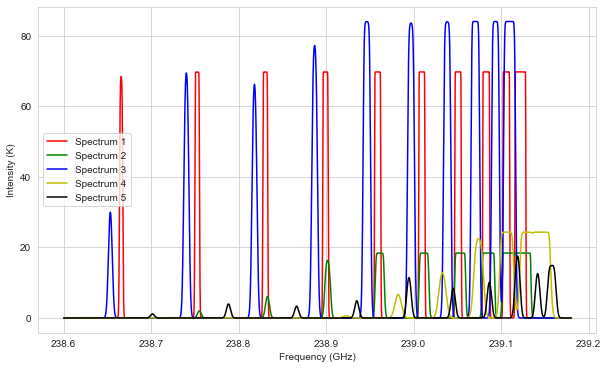

In [13]:
freq_sig = np.array(np.array_split(df_data['Frequency'], len(files)))
signal = np.array(np.array_split(df_data['Intensity'], len(files)))

# plot the signal in one plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(freq_sig[0],  signal[0], color='r', label='Spectrum 1')
plt.plot(freq_sig[1], signal[1], color='g', label='Spectrum 2')
plt.plot(freq_sig[2], signal[2], color='b', label='Spectrum 3')
plt.plot(freq_sig[3], signal[3], color='y', label='Spectrum 4')
plt.plot(freq_sig[4], signal[4], color='k', label='Spectrum 5')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (K)")
plt.legend()
plt.show()

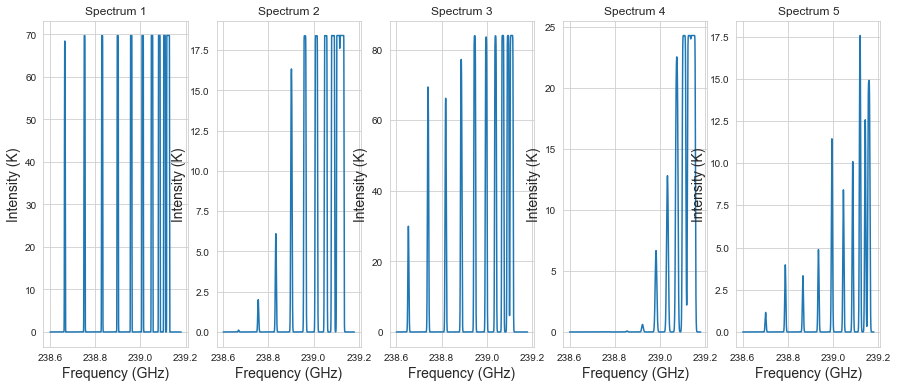

In [14]:
# plot the data in separate plots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
sns.set_style("whitegrid")
for i, ax in enumerate(axes.ravel(), start=1):
    ax.plot(freq_sig[i-1], signal[i-1], label='Spectrum {}'.format(i))
    ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
    ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
    ax.set_title("Spectrum {}".format(i))
    
# plt.savefig('../spectra/simulated_data/spectrum_plots.png')

In [15]:
# print(pywt.wavelist())

### Feature Extraction - Wavelet Decomposition

In [16]:
#create a  feature vector array for each spectrum 
feature_vector = np.zeros((len(signal), int(df_data.shape[0]/len(files))))
detail_coeffs = np.zeros((len(signal), 907))
approx_coeffs = np.zeros((len(signal), 907))
level = 6
wname = 'db35'
def decompose_signal_dwt(_signal, wavelet=wname, mode='per', level=level):
    """
    Performs wavelet denoising on the given signal.
    """
    # loop throuh all the spectra 
    for spectra_index in range(len(_signal)):
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        coeffs = pywt.wavedec(_signal[spectra_index], wavelet=wavelet, mode=mode, level=level)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        detail_coeffs[spectra_index, :] = coeff_arr[coeff_slices[1]['d']] # 4th level detail coeffs 
        # get the approximation coeffs
        approx_coeffs[spectra_index, :] = coeffs[0] # 4th level approximation coeffs
        
        reconstructed_signal = pywt.waverec(coeffs, wavelet=wavelet, mode=mode)
        feature_vector[spectra_index, :] = coeff_arr[:int(df_data.shape[0]/len(files))]
        # add the coeff_arr to the dataframe for each spectra
        # df_data['fv_dwt_{}'.format(wavelet)] = pd.Series(feature_vector.reshape(1, -1)[0], index=df_data.index) #TODO: find a way to optimize (or comment it out)
        
    return coeff_arr, coeff_slices

In [17]:
feature_vector.shape

(10000, 58000)

In [18]:
coeff_arr, coeff_slices = decompose_signal_dwt(signal)
df_data

Frequency  Intensity
0          238.60000        0.0
1          238.60001        0.0
2          238.60002        0.0
3          238.60003        0.0
4          238.60004        0.0
...              ...        ...
579999995  239.17995        0.0
579999996  239.17996        0.0
579999997  239.17997        0.0
579999998  239.17998        0.0
579999999  239.17999        0.0

[580000000 rows x 2 columns]

In [19]:
detail_coeffs.shape
detail_coeffs

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.46520274e-02,  7.58669949e-03, -3.00630584e-03, ...,
         3.25072992e-02, -3.14486286e-02,  2.35285460e-02],
       [ 9.95786260e+00,  5.77176047e+00, -1.25449977e+01, ...,
         1.22531879e+01, -3.12760107e+00, -2.29496071e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Wavelet Decomposition Plots

In [20]:
def decomposed_dwt_detail_coeffs_plots(_signal, wavelet=wname, level=level):
    """
    Plots of the detail coeffs of the signal.
    """
    # plot the reconstructed signal and the original signal in one plot
    for spectra_index in range(len(_signal)):                     
        # compute the maximum useful level of decomposition for each wavelet                        
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        fig, axes = plt.subplots(nrows=1, ncols=level, dpi=400, sharey='none', sharex='all', figsize=(18, 5))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[i]['d']], label='Level {}'.format(i))
            ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
            ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
            ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 
            
        plt.show()

In [21]:
# decomposed_dwt_detail_coeffs_plots(signal) 

In [22]:
# TODO: find a way to plot the detail coefficients of the signal
def decomposed_dwt_approx_coeffs_plots(_signal, wavelet=wname, level=level):
    
    for spectra_index in range(len(_signal)):
        fig, axes = plt.subplots(nrows=1, ncols=level, figsize=(10, 6))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[1]['d']])
            ax.set_title("Spectrum {} approximation coeffiecients at level {} for {} ".format(spectra_index+1, i,  wavelet))
            
        plt.show()

In [23]:
# decomposed_dwt_approx_coeffs_plots(signal)

### Get Features and Labels

In [24]:
# fv = np.zeros((len(signal), int(df.shape[0]/len(files))))
# for spectra_index in range(len(signal)):
#     # get the level 3 detail coefficients
#     detail_coeffs = coeff_arr[coeff_slices[3]['d']]

# fv  = detail_coeffs
# labels =dff

In [25]:
# len(signal)

approx_coeffs.shape

(10000, 907)

 #### Have a glimpse look at any of the signal and its generated detail and approximation coefficients 

In [26]:

# for spectra_index in range(len(signal)):                     
#         # compute the maximum useful level of decomposition for each wavelet                        
#         # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
#         fig, axes = plt.subplots(nrows=1, ncols=10, sharey='none', sharex='all', figsize=(20, 7))
#         sns.set_style("whitegrid")
#         for i, ax in enumerate(axes.ravel(), start=1):
#             ax.plot(signal[spectra_index], label='Spectrum {}'.format(spectra_index))
#             # ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
#             # ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
#             # ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 

#     # ax[0,1].plot(signal[spectra_index], label='original')
#     # ax[1,1].plot(approx_coeffs[spectra_index], label='spectrum {} approx coeff'.format(spectra_index+1))
#     # ax[2,1].plot(detail_coeffs[spectra_index], label='spectrum {} detail coeff'.format(spectra_index+1))
# plt.legend()
# plt.show()

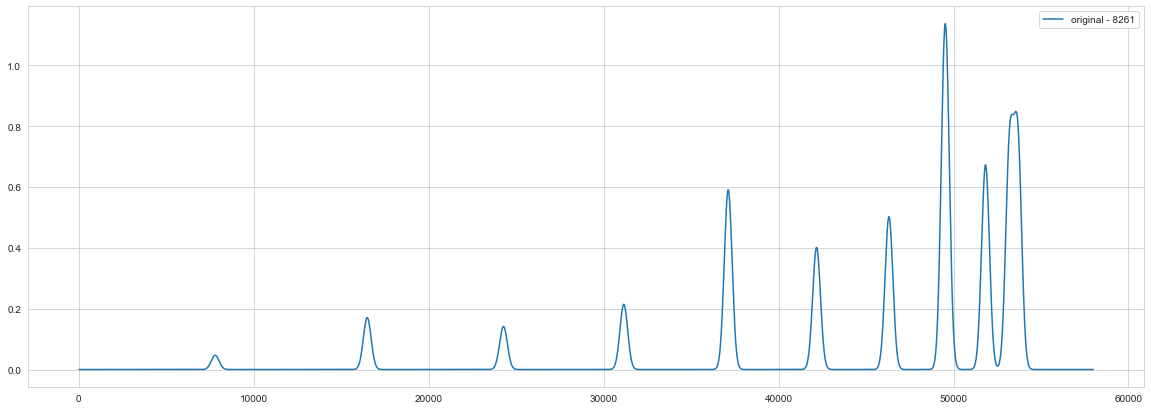

In [27]:
plt.figure(figsize=(20,7))
plt.plot(signal[8260], label='original - 8261')
plt.legend()
# plt.savefig("data/10K_gen_files/original.png")
plt.show()

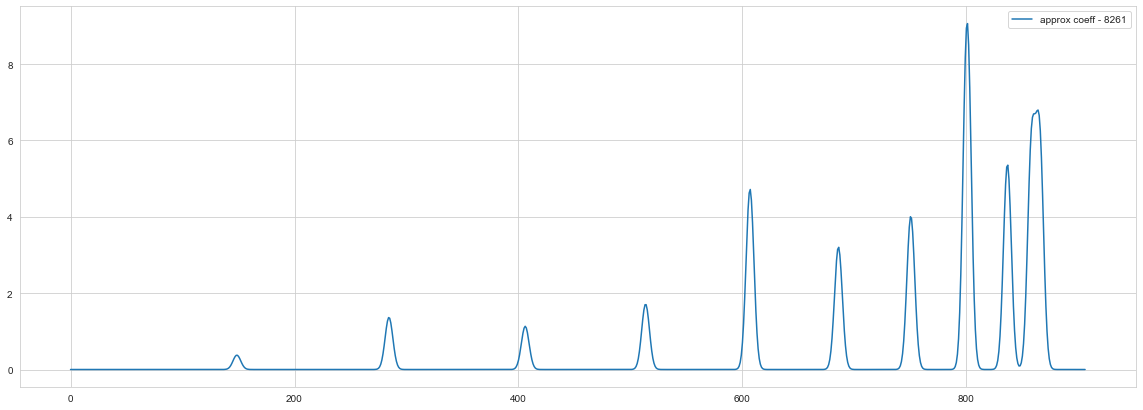

In [28]:
plt.figure(figsize=(20,7))
plt.plot(approx_coeffs[8260], label='approx coeff - 8261')
plt.legend()
# plt.savefig("data/10K_gen_files/approx_level6.png")
plt.show()

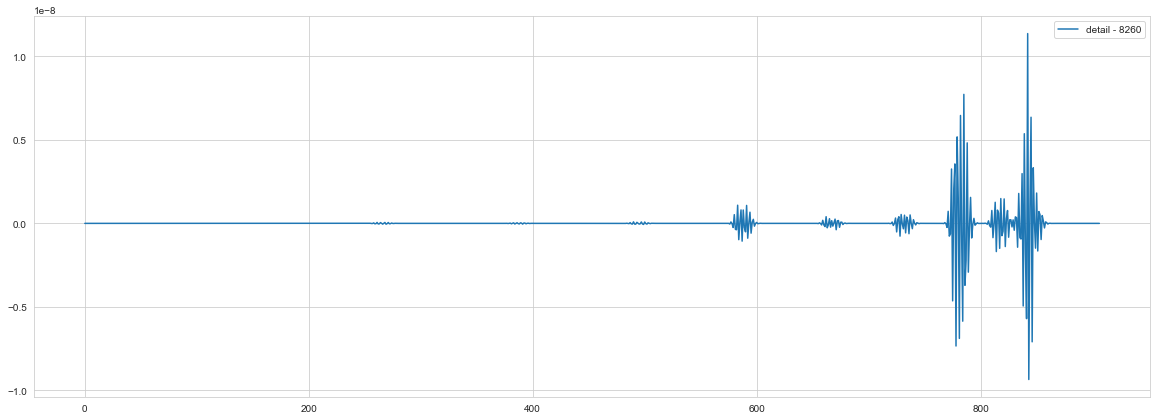

In [29]:
plt.figure(figsize=(20,7))
plt.plot(detail_coeffs[8260], label='detail - 8260')
plt.legend()
# plt.savefig("data/10K_gen_files/detail_level6.png")
plt.show()

In [30]:
features = detail_coeffs
labels_ = df_param

print('feature_shape: ', features.shape, 'labels_shape: ', labels_.shape)


feature_shape:  (10000, 907) labels_shape:  (10000, 6)


In [31]:
# drop the tcmb column
labels_.drop(columns=['tcmb'], inplace=True)

In [32]:
df = pd.DataFrame(approx_coeffs)
df.head()

0          1          2          3         4         5         6    \
0   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
1   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
2   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
3   0.173380   0.073349   0.029971   0.011830  0.004511  0.001662  0.000591   
4  50.843837  34.504674  21.402547  12.136648  6.305454  3.009765  1.323374   

        7         8         9    ...         897         898         899  \
0  0.000000  0.000000  0.000000  ...    0.000000    0.000000    0.000000   
1  0.000000  0.000000  0.000000  ...    0.000000    0.000000    0.000000   
2  0.000000  0.000000  0.000000  ...    0.000000    0.000000    0.000000   
3  0.000203  0.000068  0.000022  ...   99.638223   67.934494   42.825013   
4  0.537049  0.201469  0.069869  ...  118.372734  118.634536  118.994559   

          900         901         902         903        904        905  \
0    0.000000    0.000000    0.000000    0.000000   0.000000   0.000000   
1    0.000000    0.000000    0.000000    0.000000   0.000000   0.000000   
2    0.000000    0.000000    0.000000    0.000000   0.000000   0.000000   
3   25.251283   14.069342    7.465895    3.794107   1.853232   0.871994   
4  119.333792  118.747740  115.988429  109.908585  99.793753  85.689683   

         906  
0   0.000000  
1   0.000000  
2   0.000000  
3   0.395758  
4  68.688209  

[5 rows x 907 columns]

In [33]:
df = pd.concat([df, labels_], axis=1)
df.head()

0          1          2          3         4         5         6  \
0   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
1   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
2   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
3   0.173380   0.073349   0.029971   0.011830  0.004511  0.001662  0.000591   
4  50.843837  34.504674  21.402547  12.136648  6.305454  3.009765  1.323374   

          7         8         9  ...         902         903        904  \
0  0.000000  0.000000  0.000000  ...    0.000000    0.000000   0.000000   
1  0.000000  0.000000  0.000000  ...    0.000000    0.000000   0.000000   
2  0.000000  0.000000  0.000000  ...    0.000000    0.000000   0.000000   
3  0.000203  0.000068  0.000022  ...    7.465895    3.794107   1.853232   
4  0.537049  0.201469  0.069869  ...  115.988429  109.908585  99.793753   

         905        906       fwhm          ntot      size         tex  \
0   0.000000   0.000000   2.933735  9.035557e+18  1.332560  131.303629   
1   0.000000   0.000000   6.144747  1.329373e+18  0.388745   68.564338   
2   0.000000   0.000000   5.936799  7.038781e+17  2.270334  306.109908   
3   0.871994   0.395758  10.075154  7.898081e+16  0.465409   53.727434   
4  85.689683  68.688209   6.654279  6.687129e+16  0.464912  374.698519   

        vlsr  
0  17.020590  
1  13.937171  
2  32.571172  
3 -12.442107  
4 -27.878288  

[5 rows x 912 columns]

In [34]:
df.shape

(10000, 912)

In [35]:
# convert the ntot column to log values 
df['ntot'] = np.log10(df['ntot'])
df.head()

0          1          2          3         4         5         6  \
0   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
1   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
2   0.000000   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000   
3   0.173380   0.073349   0.029971   0.011830  0.004511  0.001662  0.000591   
4  50.843837  34.504674  21.402547  12.136648  6.305454  3.009765  1.323374   

          7         8         9  ...         902         903        904  \
0  0.000000  0.000000  0.000000  ...    0.000000    0.000000   0.000000   
1  0.000000  0.000000  0.000000  ...    0.000000    0.000000   0.000000   
2  0.000000  0.000000  0.000000  ...    0.000000    0.000000   0.000000   
3  0.000203  0.000068  0.000022  ...    7.465895    3.794107   1.853232   
4  0.537049  0.201469  0.069869  ...  115.988429  109.908585  99.793753   

         905        906       fwhm       ntot      size         tex       vlsr  
0   0.000000   0.000000   2.933735  18.955955  1.332560  131.303629  17.020590  
1   0.000000   0.000000   6.144747  18.123647  0.388745   68.564338  13.937171  
2   0.000000   0.000000   5.936799  17.847497  2.270334  306.109908  32.571172  
3   0.871994   0.395758  10.075154  16.897522  0.465409   53.727434 -12.442107  
4  85.689683  68.688209   6.654279  16.825240  0.464912  374.698519 -27.878288  

[5 rows x 912 columns]

In [36]:
X = df.iloc[:, :907]
y = df.iloc[:, -5:]

In [37]:
X

0             1             2             3             4    \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3     1.733797e-01  7.334858e-02  2.997101e-02  1.182972e-02  4.510631e-03   
4     5.084384e+01  3.450467e+01  2.140255e+01  1.213665e+01  6.305454e+00   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996 -7.072610e-35 -1.465777e-33  9.740673e-33  1.237686e-31 -6.494162e-31   
9997  3.885822e+01  5.651094e+01  7.342183e+01  8.534938e+01  9.093731e+01   
9998  1.148553e+02  1.016054e+02  8.587036e+01  6.984382e+01  5.406090e+01   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               5             6             7             8             9    \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3     1.661509e-03  5.912702e-04  2.032714e-04  6.752390e-05  2.165531e-05   
4     3.009765e+00  1.323374e+00  5.370486e-01  2.014693e-01  6.986887e-02   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996 -7.991931e-30  6.303299e-29  8.590525e-29 -2.473721e-27  8.760327e-27   
9997  8.944072e+01  8.577656e+01  8.213941e+01  8.435386e+01  8.758593e+01   
9998  4.115697e+01  3.021157e+01  2.422085e+01  2.028145e+01  2.305803e+01   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

      ...           897           898           899           900  \
0     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3     ...  9.963822e+01  6.793449e+01  4.282501e+01  2.525128e+01   
4     ...  1.183727e+02  1.186345e+02  1.189946e+02  1.193338e+02   
...   ...           ...           ...           ...           ...   
9995  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996  ...  4.050414e-50  1.191578e-49 -4.655276e-46  3.695268e-44   
9997  ...  2.609263e+00  1.019572e+00  3.734668e-01  1.911354e-01   
9998  ...  3.848798e+01  5.254089e+01  6.836569e+01  8.487053e+01   
9999  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               901           902           903           904           905  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3     1.406934e+01  7.465895e+00  3.794107e+00  1.853232e+00  8.719936e-01   
4     1.187477e+02  1.159884e+02  1.099086e+02  9.979375e+01  8.568968e+01   
...            ...           ...           ...           ...           ...   
9995  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9996 -8.209392e-43 -4.085773e-41  2.114881e-39 -1.970147e-38 -4.016528e-37   
9997  3.173063e-01  9.007854e-01  2.452245e+00  5.920261e+00  1.259870e+01   
9998  1.006523e+02  1.142070e+02  1.241659e+02  1.294992e+02  1.296391e+02   
9999  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

               906  
0     0.000000e+00  
1     0.000000e+00  
2     0.000000e+00  
3     3.957579e-01  
4     6.868821e+01  
...            ...  
9995  0.000000e+00  
9996  1.084019e-35  
9997  2.355287e+01  
9998  1.246096e+02  
9999  0.000000e+00  

[10000 rows x 907 columns]

In [38]:
y

fwhm       ntot      size         tex       vlsr
0      2.933735  18.955955  1.332560  131.303629  17.020590
1      6.144747  18.123647  0.388745   68.564338  13.937171
2      5.936799  17.847497  2.270334  306.109908  32.571172
3     10.075154  16.897522  0.465409   53.727434 -12.442107
4      6.654279  16.825240  0.464912  374.698519 -27.878288
...         ...        ...       ...         ...        ...
9995   4.909492  18.609729  1.719104  348.597741   6.530393
9996  10.977503  16.330423  0.664250  336.116661  49.761659
9997   5.506002  16.027427  1.213782  300.825404 -40.673135
9998   8.829258  16.416385  1.857922  342.955614 -52.942065
9999   4.976429  16.250681  0.369198   78.534453   2.518707

[10000 rows x 5 columns]

#### split the data into the training and test set

In [39]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
    )

print('X_train shape: ',  X_train.shape, '\n',
    'y_train shape: ', y_train.shape, '\n',
    'X_test shape: ', X_test.shape, '\n',
    'y_test shape: ', y_test.shape)

X_train shape:  (7000, 907) 
 y_train shape:  (7000, 5) 
 X_test shape:  (3000, 907) 
 y_test shape:  (3000, 5)


In [40]:
# get the original data indices for the test data and save them in a csv file
testing_data_indices = pd.DataFrame(X_test.index)
testing_data_indices.to_csv(output_path + "testing_data_indices.csv")

## 1. Multioutput Regressor - RF

In [41]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

# tuned model to use instantly
regr_multirf = MultiOutputRegressor(
    estimator=RandomForestRegressor(
        bootstrap='False',
        max_depth=90,
        max_features='log2',
        max_samples=0.8999999999999999,
        n_estimators=700,
        n_jobs=-1,
        random_state=7,
        verbose=2
))


# # from tuned model
# regr_multirf = MultiOutputRegressor(
#     estimator=RandomForestRegressor(
#        n_estimators=800, 
#        min_samples_split=2,
#        min_samples_leaf=1,
#        max_features='auto', 
#        max_depth=130,
#        bootstrap=True,
#        verbose=42
#     )
# )


# multioutput regressor+
regr_multirf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700
building tree 7 of 700
building tree 8 of 700
building tree 6 of 700
building tree 5 of 700
building tree 1 of 700
building tree 3 of 700
building tree 4 of 700
building tree 9 of 700
building tree 11 of 700building tree 10 of 700

building tree 12 of 700
building tree 14 of 700
building tree 13 of 700
building tree 16 of 700
building tree 15 of 700
building tree 17 of 700
building tree 18 of 700
building tree 19 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 24 of 700
building tree 23 of 700
building tree 25 of 700
building tree 26 of 700building tree 27 of 700

building tree 28 of 700
building tree 29 of 700
building tree 30 of 700
building tree 31 of 700
building tree 32 of 700
building tree 33 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700
building tree 38 of 700
building tree 39 of 700
building tree 40 of 700


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.1s


building tree 41 of 700
building tree 42 of 700
building tree 43 of 700
building tree 44 of 700
building tree 46 of 700
building tree 45 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 52 of 700
building tree 53 of 700
building tree 54 of 700
building tree 55 of 700
building tree 56 of 700
building tree 57 of 700
building tree 58 of 700
building tree 59 of 700
building tree 60 of 700
building tree 61 of 700
building tree 62 of 700
building tree 63 of 700
building tree 64 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 68 of 700
building tree 69 of 700
building tree 70 of 700
building tree 71 of 700
building tree 72 of 700
building tree 73 of 700
building tree 74 of 700
building tree 75 of 700
building tree 76 of 700
building tree 77 of 700
building tree 78 of 700
building tree 80 of 700
building tree 79 of 700
building tree 81 of 700
building tree 82

[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    9.8s


building tree 172 of 700
building tree 178 of 700
building tree 180 of 700
building tree 182 of 700
building tree 184 of 700
building tree 185 of 700
building tree 187 of 700
building tree 189 of 700
building tree 191 of 700
building tree 193 of 700
building tree 195 of 700
building tree 197 of 700
building tree 199 of 700
building tree 186 of 700
building tree 188 of 700
building tree 192 of 700
building tree 190 of 700
building tree 196 of 700
building tree 194 of 700
building tree 198 of 700
building tree 200 of 700
building tree 201 of 700
building tree 203 of 700
building tree 205 of 700
building tree 207 of 700
building tree 209 of 700
building tree 211 of 700
building tree 213 of 700
building tree 215 of 700
building tree 204 of 700
building tree 202 of 700
building tree 206 of 700
building tree 208 of 700
building tree 212 of 700
building tree 210 of 700
building tree 214 of 700
building tree 216 of 700
building tree 217 of 700
building tree 219 of 700
building tree 221 of 700


[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:   14.4s


building tree 572 of 700
building tree 578 of 700
building tree 576 of 700
building tree 584 of 700
building tree 580 of 700
building tree 582 of 700
building tree 585 of 700
building tree 587 of 700
building tree 589 of 700
building tree 593 of 700
building tree 591 of 700
building tree 586 of 700
building tree 599 of 700building tree 595 of 700

building tree 597 of 700
building tree 590 of 700
building tree 592 of 700
building tree 588 of 700
building tree 594 of 700
building tree 598 of 700
building tree 596 of 700
building tree 600 of 700
building tree 601 of 700
building tree 603 of 700
building tree 605 of 700
building tree 607 of 700
building tree 609 of 700
building tree 611 of 700
building tree 613 of 700
building tree 602 of 700
building tree 606 of 700
building tree 604 of 700
building tree 608 of 700
building tree 610 of 700
building tree 615 of 700
building tree 612 of 700
building tree 614 of 700
building tree 617 of 700
building tree 616 of 700
building tree 619 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   15.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700
building tree 2 of 700
building tree 5 of 700building tree 6 of 700

building tree 7 of 700
building tree 4 of 700
building tree 3 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 18 of 700
building tree 22 of 700
building tree 20 of 700
building tree 24 of 700
building tree 26 of 700
building tree 32 of 700
building tree 30 of 700
building tree 28 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
building tree 34 of 700
building tree 36 of 700bu

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s


building tree 53 of 700
building tree 55 of 700
building tree 57 of 700
building tree 59 of 700
building tree 61 of 700
building tree 63 of 700
building tree 50 of 700
building tree 52 of 700
building tree 54 of 700
building tree 56 of 700
building tree 58 of 700
building tree 62 of 700
building tree 60 of 700
building tree 64 of 700
building tree 65 of 700
building tree 67 of 700
building tree 69 of 700
building tree 71 of 700
building tree 73 of 700
building tree 75 of 700
building tree 77 of 700
building tree 79 of 700
building tree 66 of 700
building tree 70 of 700
building tree 68 of 700
building tree 72 of 700
building tree 74 of 700
building tree 76 of 700
building tree 78 of 700
building tree 80 of 700
building tree 81 of 700
building tree 83 of 700
building tree 85 of 700
building tree 87 of 700
building tree 89 of 700
building tree 91 of 700
building tree 93 of 700
building tree 95 of 700
building tree 82 of 700
building tree 84 of 700
building tree 86 of 700
building tree 88

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.0s


building tree 297 of 700
building tree 292 of 700
building tree 299 of 700
building tree 301 of 700
building tree 294 of 700
building tree 303 of 700
building tree 296 of 700
building tree 305 of 700
building tree 300 of 700
building tree 298 of 700
building tree 302 of 700
building tree 304 of 700
building tree 307 of 700
building tree 306 of 700
building tree 309 of 700
building tree 311 of 700
building tree 313 of 700
building tree 315 of 700
building tree 317 of 700
building tree 319 of 700
building tree 308 of 700
building tree 321 of 700
building tree 310 of 700
building tree 312 of 700
building tree 314 of 700
building tree 316 of 700
building tree 318 of 700
building tree 320 of 700
building tree 322 of 700
building tree 323 of 700
building tree 325 of 700
building tree 327 of 700
building tree 329 of 700
building tree 331 of 700
building tree 333 of 700
building tree 335 of 700
building tree 324 of 700
building tree 337 of 700
building tree 328 of 700
building tree 332 of 700


[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:   10.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 4 of 700building tree 3 of 700

building tree 1 of 700
building tree 5 of 700
building tree 2 of 700
building tree 6 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 24 of 700
building tree 18 of 700
building tree 20 of 700
building tree 30 of 700
building tree 28 of 700
building tree 26 of 700
building tree 22 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
building tree 36 of 700
building tree 34 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s


building tree 50 of 700
building tree 56 of 700
building tree 52 of 700
building tree 58 of 700
building tree 54 of 700
building tree 60 of 700
building tree 62 of 700
building tree 64 of 700
building tree 65 of 700
building tree 67 of 700
building tree 69 of 700
building tree 71 of 700
building tree 73 of 700
building tree 75 of 700
building tree 77 of 700
building tree 79 of 700
building tree 66 of 700
building tree 68 of 700
building tree 70 of 700
building tree 72 of 700
building tree 74 of 700
building tree 76 of 700
building tree 80 of 700
building tree 78 of 700
building tree 81 of 700
building tree 83 of 700
building tree 85 of 700
building tree 87 of 700
building tree 89 of 700
building tree 91 of 700
building tree 93 of 700
building tree 82 of 700
building tree 95 of 700
building tree 86 of 700
building tree 88 of 700
building tree 84 of 700
building tree 90 of 700
building tree 94 of 700
building tree 92 of 700
building tree 96 of 700
building tree 97 of 700
building tree 99

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.7s


building tree 288 of 700
building tree 293 of 700
building tree 295 of 700
building tree 297 of 700
building tree 299 of 700
building tree 290 of 700
building tree 292 of 700
building tree 301 of 700
building tree 303 of 700
building tree 294 of 700
building tree 298 of 700
building tree 296 of 700
building tree 300 of 700
building tree 302 of 700
building tree 305 of 700
building tree 307 of 700
building tree 304 of 700
building tree 309 of 700
building tree 311 of 700
building tree 313 of 700
building tree 306 of 700
building tree 315 of 700
building tree 317 of 700
building tree 308 of 700
building tree 319 of 700
building tree 310 of 700
building tree 314 of 700
building tree 312 of 700
building tree 316 of 700
building tree 321 of 700
building tree 318 of 700
building tree 323 of 700
building tree 320 of 700
building tree 325 of 700
building tree 327 of 700
building tree 329 of 700
building tree 331 of 700
building tree 322 of 700
building tree 324 of 700
building tree 333 of 700


[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 3 of 700
building tree 2 of 700
building tree 4 of 700
building tree 5 of 700
building tree 7 of 700
building tree 1 of 700
building tree 6 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 12 of 700
building tree 20 of 700
building tree 18 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 33 of 700
building tree 35 of 700
building tree 26 of 700
building tree 22 of 700
building tree 24 of 700
building tree 30 of 700
building tree 28 of 700
building tree 32 of 700
building tree 37 of 700
building tree 34 of 700
building tree 36 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s


building tree 38 of 700
building tree 40 of 700
building tree 42 of 700
building tree 44 of 700
building tree 49 of 700
building tree 46 of 700
building tree 48 of 700
building tree 51 of 700
building tree 53 of 700
building tree 50 of 700
building tree 52 of 700
building tree 55 of 700
building tree 57 of 700
building tree 59 of 700
building tree 61 of 700
building tree 63 of 700
building tree 54 of 700
building tree 56 of 700
building tree 65 of 700
building tree 58 of 700
building tree 67 of 700
building tree 60 of 700
building tree 62 of 700
building tree 69 of 700
building tree 64 of 700
building tree 66 of 700
building tree 68 of 700
building tree 71 of 700
building tree 73 of 700
building tree 75 of 700
building tree 77 of 700
building tree 70 of 700
building tree 79 of 700
building tree 81 of 700
building tree 83 of 700
building tree 72 of 700
building tree 74 of 700
building tree 76 of 700
building tree 78 of 700
building tree 85 of 700
building tree 80 of 700
building tree 82

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.1s


building tree 304 of 700
building tree 306 of 700
building tree 307 of 700
building tree 309 of 700
building tree 311 of 700
building tree 313 of 700
building tree 315 of 700
building tree 317 of 700
building tree 319 of 700
building tree 321 of 700
building tree 308 of 700
building tree 314 of 700
building tree 312 of 700
building tree 310 of 700
building tree 316 of 700
building tree 320 of 700
building tree 318 of 700
building tree 322 of 700
building tree 323 of 700
building tree 325 of 700
building tree 324 of 700
building tree 327 of 700
building tree 326 of 700
building tree 333 of 700
building tree 331 of 700
building tree 329 of 700
building tree 335 of 700
building tree 337 of 700
building tree 328 of 700
building tree 339 of 700
building tree 330 of 700
building tree 334 of 700
building tree 332 of 700
building tree 336 of 700
building tree 338 of 700
building tree 340 of 700
building tree 341 of 700
building tree 343 of 700
building tree 347 of 700
building tree 345 of 700


[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    8.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    8.1s finished


building tree 691 of 700
building tree 687 of 700
building tree 690 of 700
building tree 689 of 700
building tree 693 of 700
building tree 692 of 700
building tree 694 of 700
building tree 686 of 700
building tree 688 of 700
building tree 695 of 700
building tree 696 of 700
building tree 697 of 700
building tree 698 of 700
building tree 699 of 700
building tree 700 of 700


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700building tree 1 of 700
building tree 3 of 700

building tree 4 of 700
building tree 6 of 700
building tree 7 of 700building tree 8 of 700
building tree 5 of 700

building tree 9 of 700
building tree 11 of 700building tree 10 of 700

building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 24 of 700
building tree 28 of 700
building tree 26 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 34 of 700
building tree 45 of 700
building tree 36 of 700
building tree 38 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s


building tree 51 of 700
building tree 53 of 700
building tree 55 of 700
building tree 48 of 700
building tree 57 of 700
building tree 50 of 700
building tree 59 of 700
building tree 61 of 700
building tree 52 of 700
building tree 54 of 700
building tree 56 of 700
building tree 63 of 700
building tree 58 of 700
building tree 60 of 700
building tree 62 of 700
building tree 65 of 700
building tree 64 of 700
building tree 67 of 700
building tree 66 of 700
building tree 71 of 700
building tree 73 of 700
building tree 69 of 700
building tree 75 of 700
building tree 77 of 700
building tree 68 of 700
building tree 74 of 700
building tree 72 of 700
building tree 70 of 700
building tree 78 of 700
building tree 76 of 700
building tree 79 of 700
building tree 81 of 700
building tree 83 of 700
building tree 85 of 700
building tree 87 of 700
building tree 89 of 700
building tree 91 of 700
building tree 80 of 700
building tree 93 of 700
building tree 82 of 700
building tree 84 of 700
building tree 86

[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.0s


building tree 307 of 700
building tree 304 of 700
building tree 306 of 700
building tree 311 of 700
building tree 309 of 700
building tree 313 of 700
building tree 308 of 700
building tree 310 of 700
building tree 312 of 700
building tree 314 of 700
building tree 315 of 700
building tree 323 of 700
building tree 321 of 700
building tree 317 of 700
building tree 319 of 700
building tree 325 of 700
building tree 327 of 700
building tree 316 of 700
building tree 329 of 700
building tree 324 of 700
building tree 322 of 700
building tree 320 of 700
building tree 318 of 700
building tree 326 of 700
building tree 328 of 700
building tree 330 of 700
building tree 331 of 700
building tree 332 of 700
building tree 333 of 700
building tree 335 of 700
building tree 337 of 700
building tree 341 of 700building tree 345 of 700

building tree 339 of 700building tree 343 of 700

building tree 336 of 700
building tree 334 of 700
building tree 338 of 700
building tree 347 of 700
building tree 340 of 700


[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    7.8s remaining:    0.2s


building tree 691 of 700
building tree 693 of 700
building tree 692 of 700
building tree 695 of 700
building tree 694 of 700
building tree 696 of 700
building tree 698 of 700
building tree 697 of 700
building tree 699 of 700
building tree 700 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    8.0s finished


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap='False',
                                                     max_depth=90,
                                                     max_features='log2',
                                                     max_samples=0.8999999999999999,
                                                     n_estimators=700,
                                                     n_jobs=-1, random_state=7,
                                                     verbose=2))

In [42]:
#  predict on the new test data
y_multirf_pred = regr_multirf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(

In [43]:
regr_multirf.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(

0.8394944926396007

### Metrics

In [44]:
class RegressionMetrics:
    def __init__(self):
        self.metrics = {
            "mae": self._mean_absolute_error,
            "mse": self._mean_squared_error,
            "rmse": self._root_mean_squared_error,
            "mape": self._mean_absolute_percentage_error,
            "r2": self._r2_score,
            "msle": self._mean_squared_log_error,
            # "rmsle": self._root_mean_squared_logarithmic_error,
        }

    def get_metric(self, metric,  y_true, y_pred):
        if metric not in self.metrics:
            raise Exception("Metric not found")
        
        if metric == "mae":
            return self._mean_absolute_error(y_true, y_pred)
        if metric == "mse":
            return self._mean_squared_error(y_true, y_pred)
        if metric == "rmse":
            return self._root_mean_squared_error(y_true, y_pred)
        if metric == "mape":
            return self._mean_absolute_percentage_error(y_true, y_pred)
        if metric == "r2":
            return self._r2_score(y_true, y_pred)
        if metric == "msle":
            return self._mean_squared_log_error(y_true, y_pred)
        # if metric == "rmsle":
        #     return self._root_mean_squared_logarithmic_error(y_true, y_pred)
        
    @staticmethod
    def _mean_absolute_error(y_true, y_pred):
        return metrics.mean_absolute_error(y_true, y_pred)

    @staticmethod
    def _mean_squared_error(y_true, y_pred):
        return metrics.mean_squared_error(y_true, y_pred)

    def _root_mean_squared_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    def _mean_absolute_percentage_error(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    @staticmethod
    def _r2_score(y_true, y_pred):
        return metrics.r2_score(y_true, y_pred)
    
    def _mean_squared_log_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    
    # TODO: investigate in the case where it gives an error
    # def _root_mean_squared_logarithmic_error(self, y_true, y_pred):
    #     return np.sqrt(np.mean(np.square(np.log(y_pred + 1) - np.log(y_true + 1))))

In [45]:
# get the metricl for the multirf regressor
metrics_multirf = RegressionMetrics()
_metrics = ['mae', 'mse', 'rmse', 'mape', 'r2', 'msle']
for metric in _metrics:
    print("Multirf  {}: ".format(metric), metrics_multirf.get_metric(metric, y_test, y_multirf_pred))

Multirf  mae:  10.15516090731177
Multirf  mse:  752.5056656287518
Multirf  rmse:  27.4318367162819
Multirf  mape:  fwhm     9.389539
ntot     1.748700
size    27.579550
tex     34.240226
vlsr     5.029442
dtype: float64
Multirf  r2:  0.8394944926396007
Multirf  msle:  27.4318367162819


### save the true params used for the training set to a file

In [46]:
test_values = y_test.values
df_true_params = pd.DataFrame(test_values, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'], index=X_test.index)
df_true_params['ntot'] = np.array(10**df_true_params['ntot'])
df_true_params.to_csv("data/10K_gen_files/true_param_vals.csv")
df_true_params.head()

fwhm          ntot      size         tex       vlsr
6252  4.376518  2.172053e+18  1.037283  211.416223 -17.763557
4684  1.259056  9.149960e+16  1.913540   69.341427  13.110974
1731  3.166229  3.556430e+16  0.228809   17.409743   1.464466
4742  2.340026  1.211247e+16  1.979907  389.335414  28.010385
4521  3.609998  1.229299e+18  1.737984  235.127786  34.854634

### save the predicted parameters to a csv file 

In [47]:
param_df_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm_rf_pred', 'ntot_rf_pred', 'size_rf_pred', 'tex_rf_pred', 'vlsr_rf_pred'], index=X_test.index)
param_df_rf.head()

fwhm_rf_pred  ntot_rf_pred  size_rf_pred  tex_rf_pred  vlsr_rf_pred
6252      4.525254     18.183073      1.269667   235.071646    -17.777670
4684      2.201436     17.248710      1.737912   165.966694     14.376482
1731      2.766370     16.594166      0.434127    55.437526      0.275426
4742      2.333689     16.743480      0.779879   237.740647     27.898636
4521      3.612381     18.109321      1.857634   238.966870     34.510346

In [48]:
# convert back the log to linear values 
param_df_rf['ntot_rf_pred'] = np.array(10**param_df_rf['ntot_rf_pred'])
param_df_rf.head()

fwhm_rf_pred  ntot_rf_pred  size_rf_pred  tex_rf_pred  vlsr_rf_pred
6252      4.525254  1.524310e+18      1.269667   235.071646    -17.777670
4684      2.201436  1.773004e+17      1.737912   165.966694     14.376482
1731      2.766370  3.927952e+16      0.434127    55.437526      0.275426
4742      2.333689  5.539620e+16      0.779879   237.740647     27.898636
4521      3.612381  1.286238e+18      1.857634   238.966870     34.510346

In [49]:
param_df_rf.to_csv('data/10K_gen_files/predicted_parameters_rf.csv', index=True)
param_df_rf.shape

(3000, 5)

In [50]:
pred_para = pd.read_csv('data/10K_gen_files/predicted_parameters_rf.csv')
true_para = pd.read_csv('data/10K_gen_files/true_param_vals.csv')

# add the predicted value to the true value dataframe as new columns separated by an empty column 
true_para = pd.concat([true_para,  pd.DataFrame(np.zeros(len(true_para))), pred_para], axis=1)
true_para.to_csv('data/10K_gen_files/true_param_vals_with_predicted_rf.csv')
true_para.head()

Unnamed: 0      fwhm          ntot      size         tex       vlsr    0  \
0        6252  4.376518  2.172053e+18  1.037283  211.416223 -17.763557  0.0   
1        4684  1.259056  9.149960e+16  1.913540   69.341427  13.110974  0.0   
2        1731  3.166229  3.556430e+16  0.228809   17.409743   1.464466  0.0   
3        4742  2.340026  1.211247e+16  1.979907  389.335414  28.010385  0.0   
4        4521  3.609998  1.229299e+18  1.737984  235.127786  34.854634  0.0   

   Unnamed: 0  fwhm_rf_pred  ntot_rf_pred  size_rf_pred  tex_rf_pred  \
0        6252      4.525254  1.524310e+18      1.269667   235.071646   
1        4684      2.201436  1.773004e+17      1.737912   165.966694   
2        1731      2.766370  3.927952e+16      0.434127    55.437526   
3        4742      2.333689  5.539620e+16      0.779879   237.740647   
4        4521      3.612381  1.286238e+18      1.857634   238.966870   

   vlsr_rf_pred  
0    -17.777670  
1     14.376482  
2      0.275426  
3     27.898636  
4     34.510346

### Predicted vs True values plots

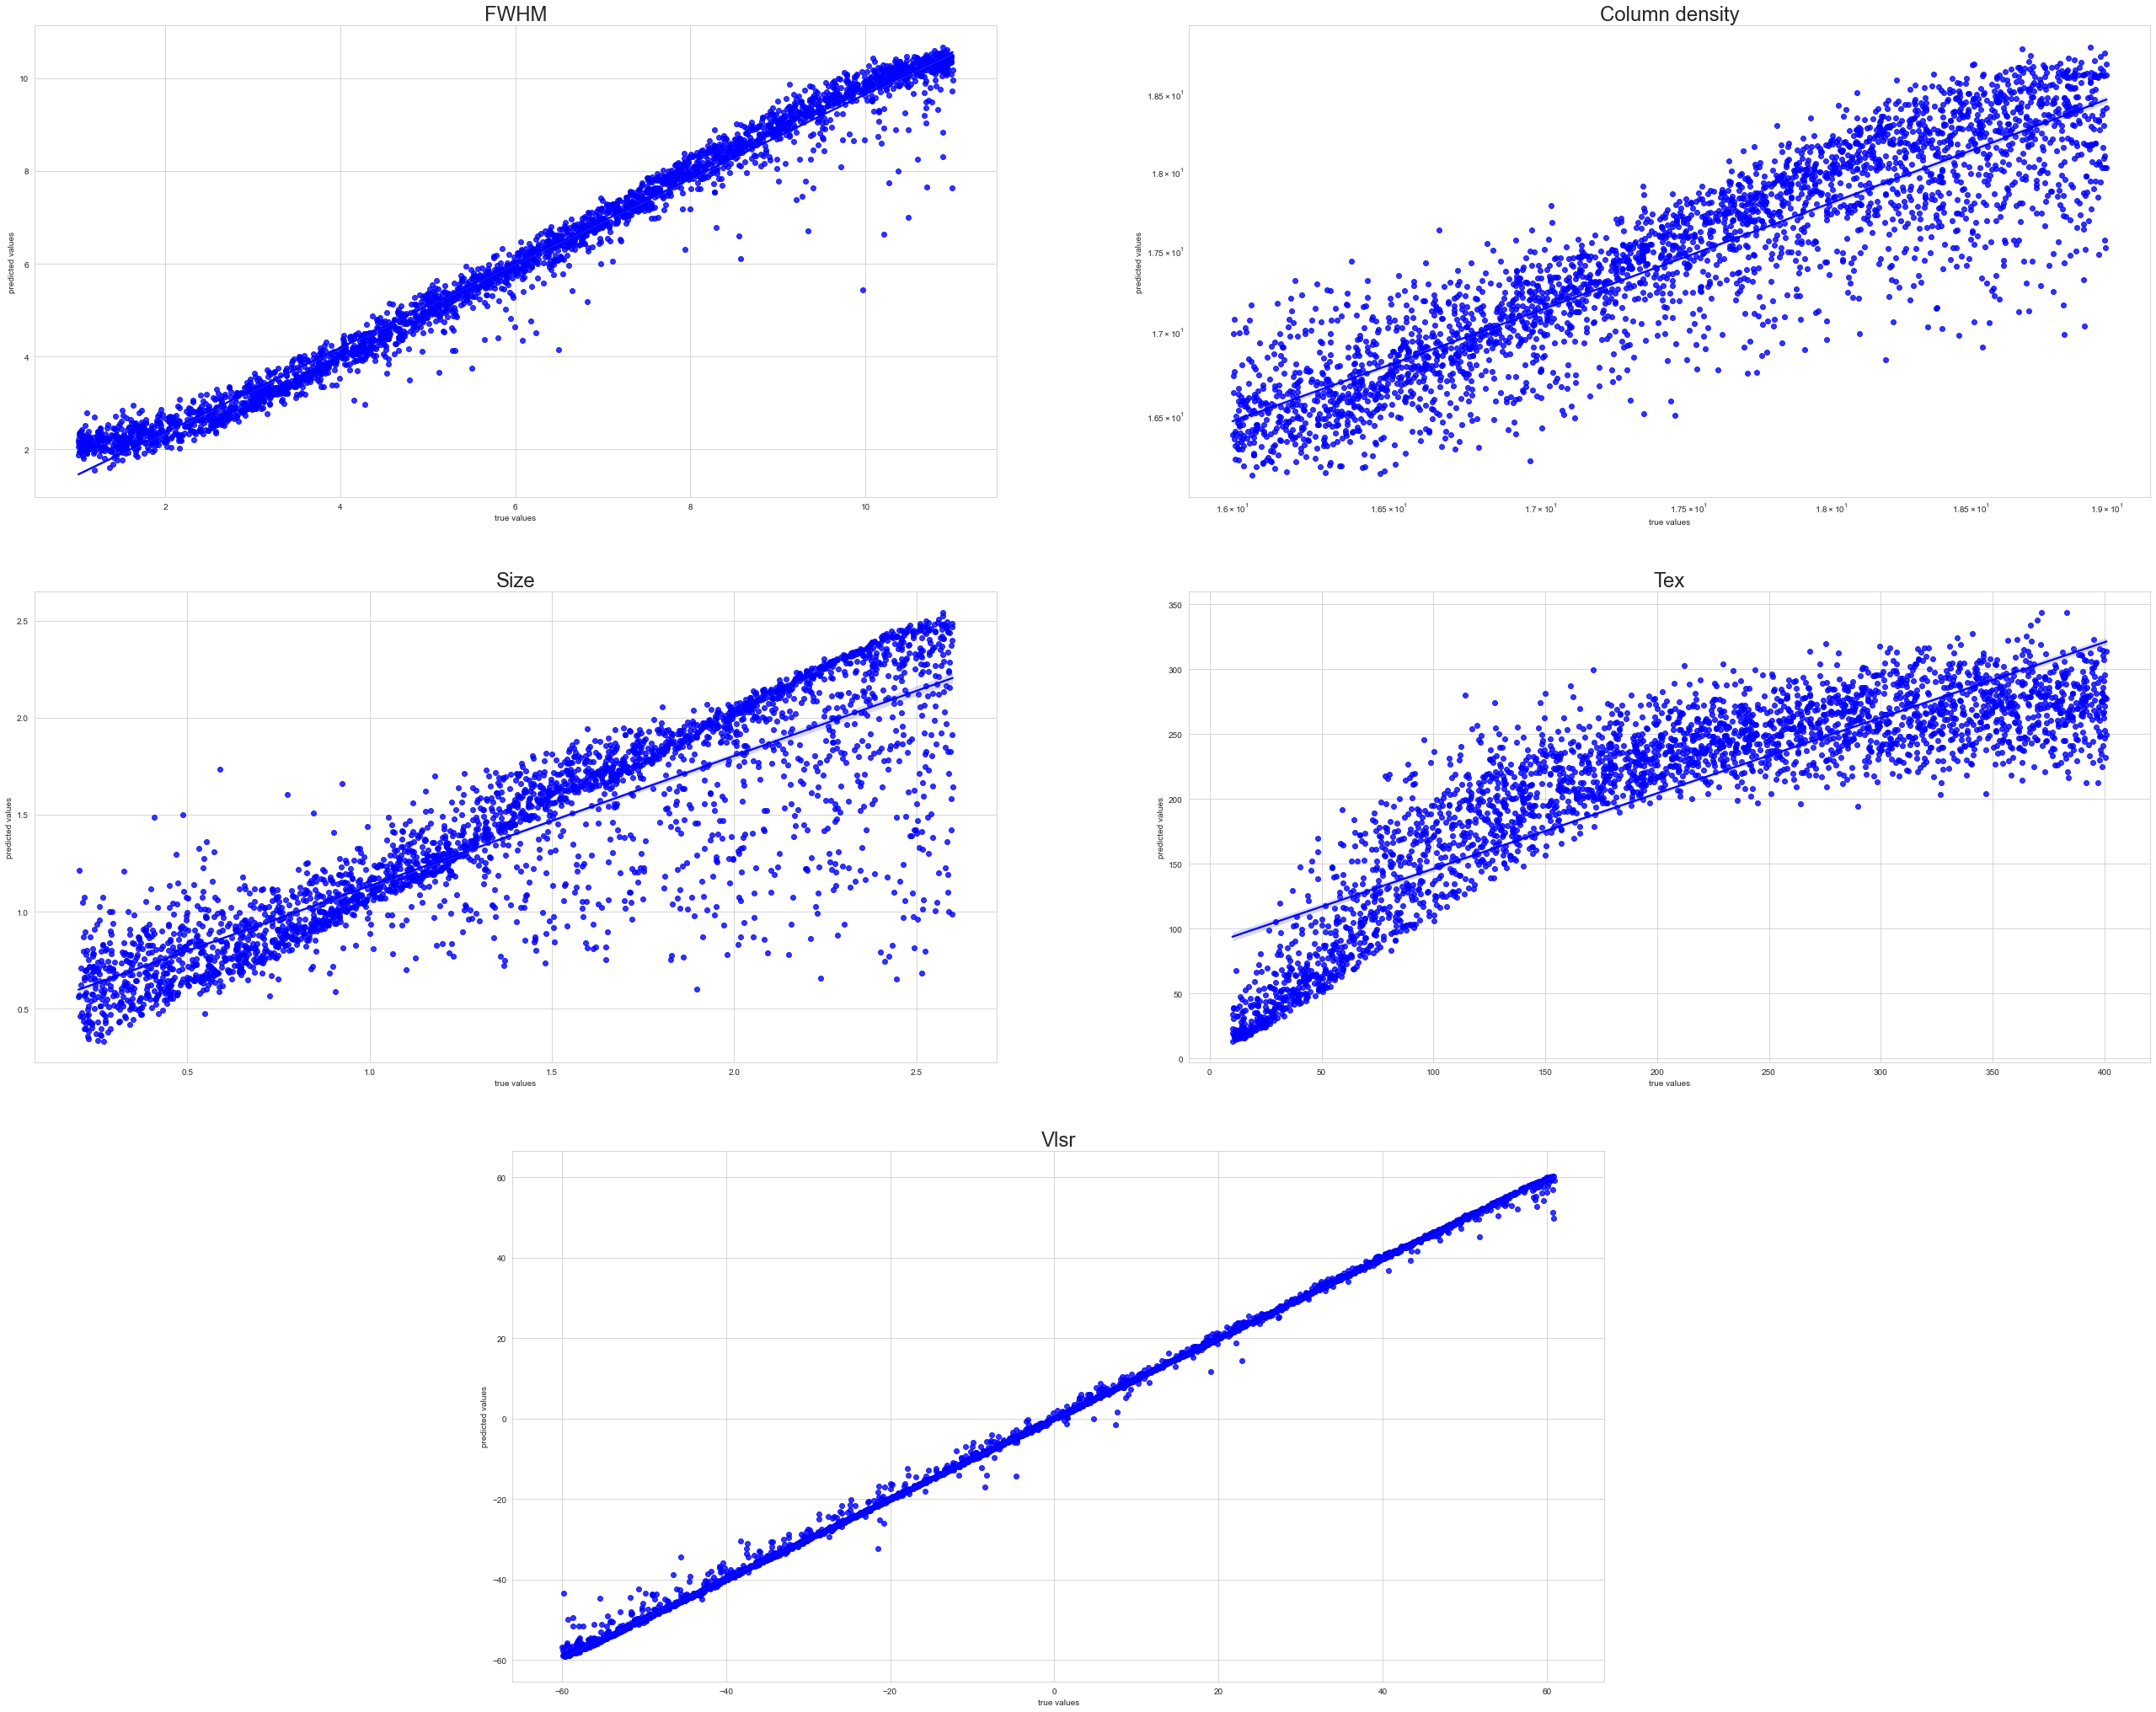

In [51]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_pred[:,0], color='blue', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_pred[:,1], color='blue', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_pred[:,2], color='blue', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_pred[:,3], color='blue', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_pred[:,4], color='blue', ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/10K_gen_files/pred_true_10K_RF.png")
plt.show()

### 3D plots -  Columnn density, Excitation temperature and Size

In [53]:
pred_param_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_rf['ntot'] = np.array(10**pred_param_rf['ntot'])
pred_param_rf.head()

fwhm          ntot      size         tex       vlsr
0  4.525254  1.524310e+18  1.269667  235.071646 -17.777670
1  2.201436  1.773004e+17  1.737912  165.966694  14.376482
2  2.766370  3.927952e+16  0.434127   55.437526   0.275426
3  2.333689  5.539620e+16  0.779879  237.740647  27.898636
4  3.612381  1.286238e+18  1.857634  238.966870  34.510346

### Residuals 3D plot -  Random Forest Regressor

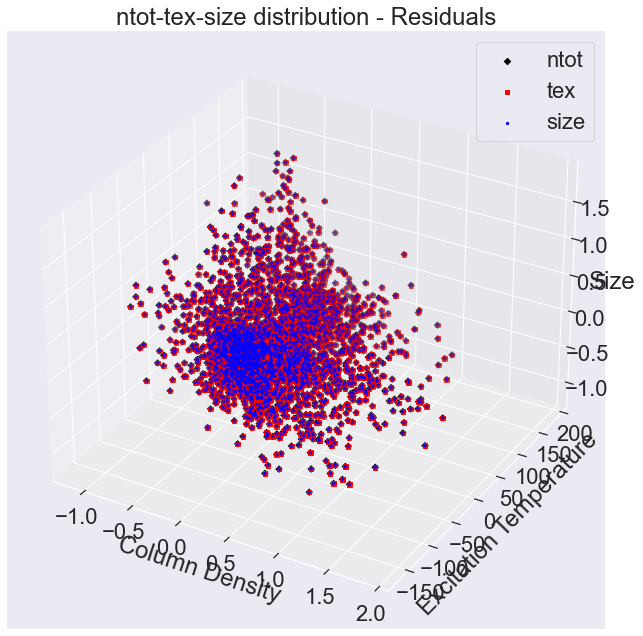

In [54]:
fig = plt.figure(figsize=(26, 11))
plt.setp(ax.get_xticklabels(), fontsize=12)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_rf = (y_test - y_multirf_pred)
# residuals
x1 = residuals_rf['ntot']
y1 = residuals_rf['tex']
z1 = residuals_rf['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

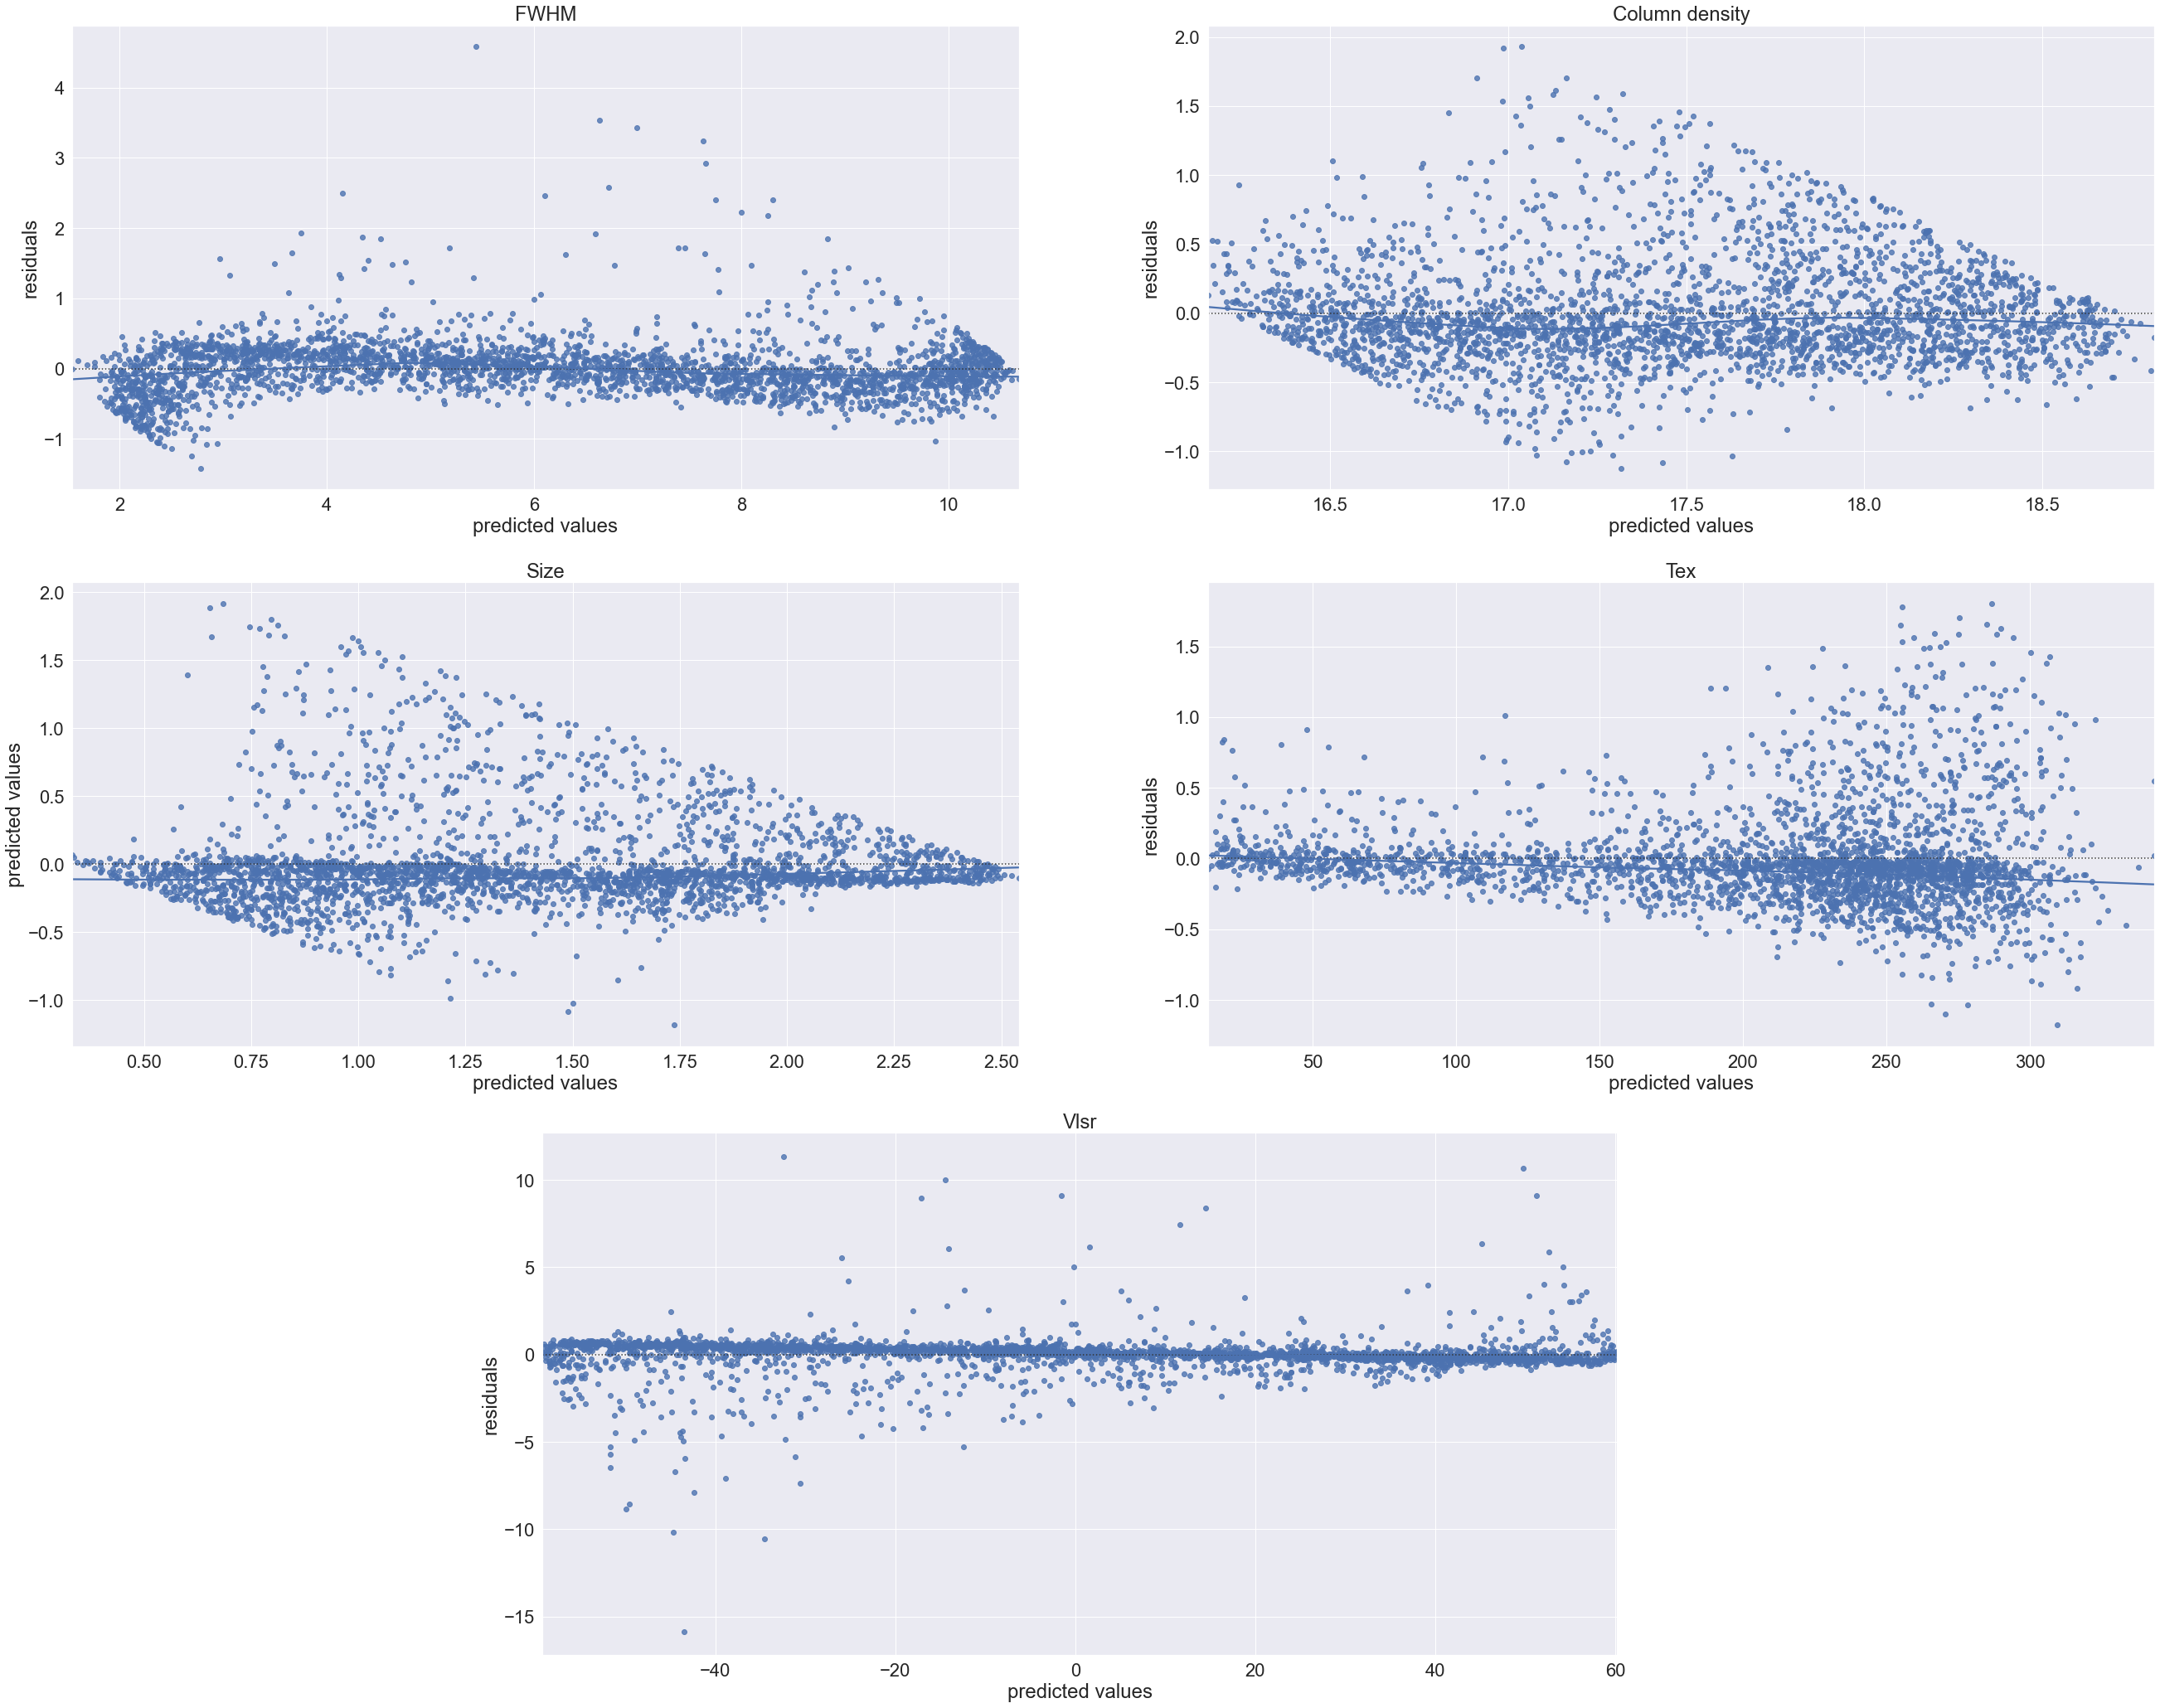

In [55]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multirf_pred[:,0], y=residuals_rf['fwhm'], lowess=True, ax=axes[0,0]) # fwhm
g2 = sns.residplot(x=y_multirf_pred[:,1], y=residuals_rf['ntot'], lowess=True, ax=axes[0,1]) # column density
g3 = sns.residplot(x=y_multirf_pred[:,2], y=residuals_rf['size'], lowess=True, ax=axes[1,0]) # size
g4 = sns.residplot(x=y_multirf_pred[:,3], y=residuals_rf['size'], lowess=True, ax=axes[1,1]) # tex
g5 = sns.residplot(x=y_multirf_pred[:,4], y=residuals_rf['vlsr'], lowess=True, ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/10K_gen_files/residuals_RF_10K.png")
plt.show()

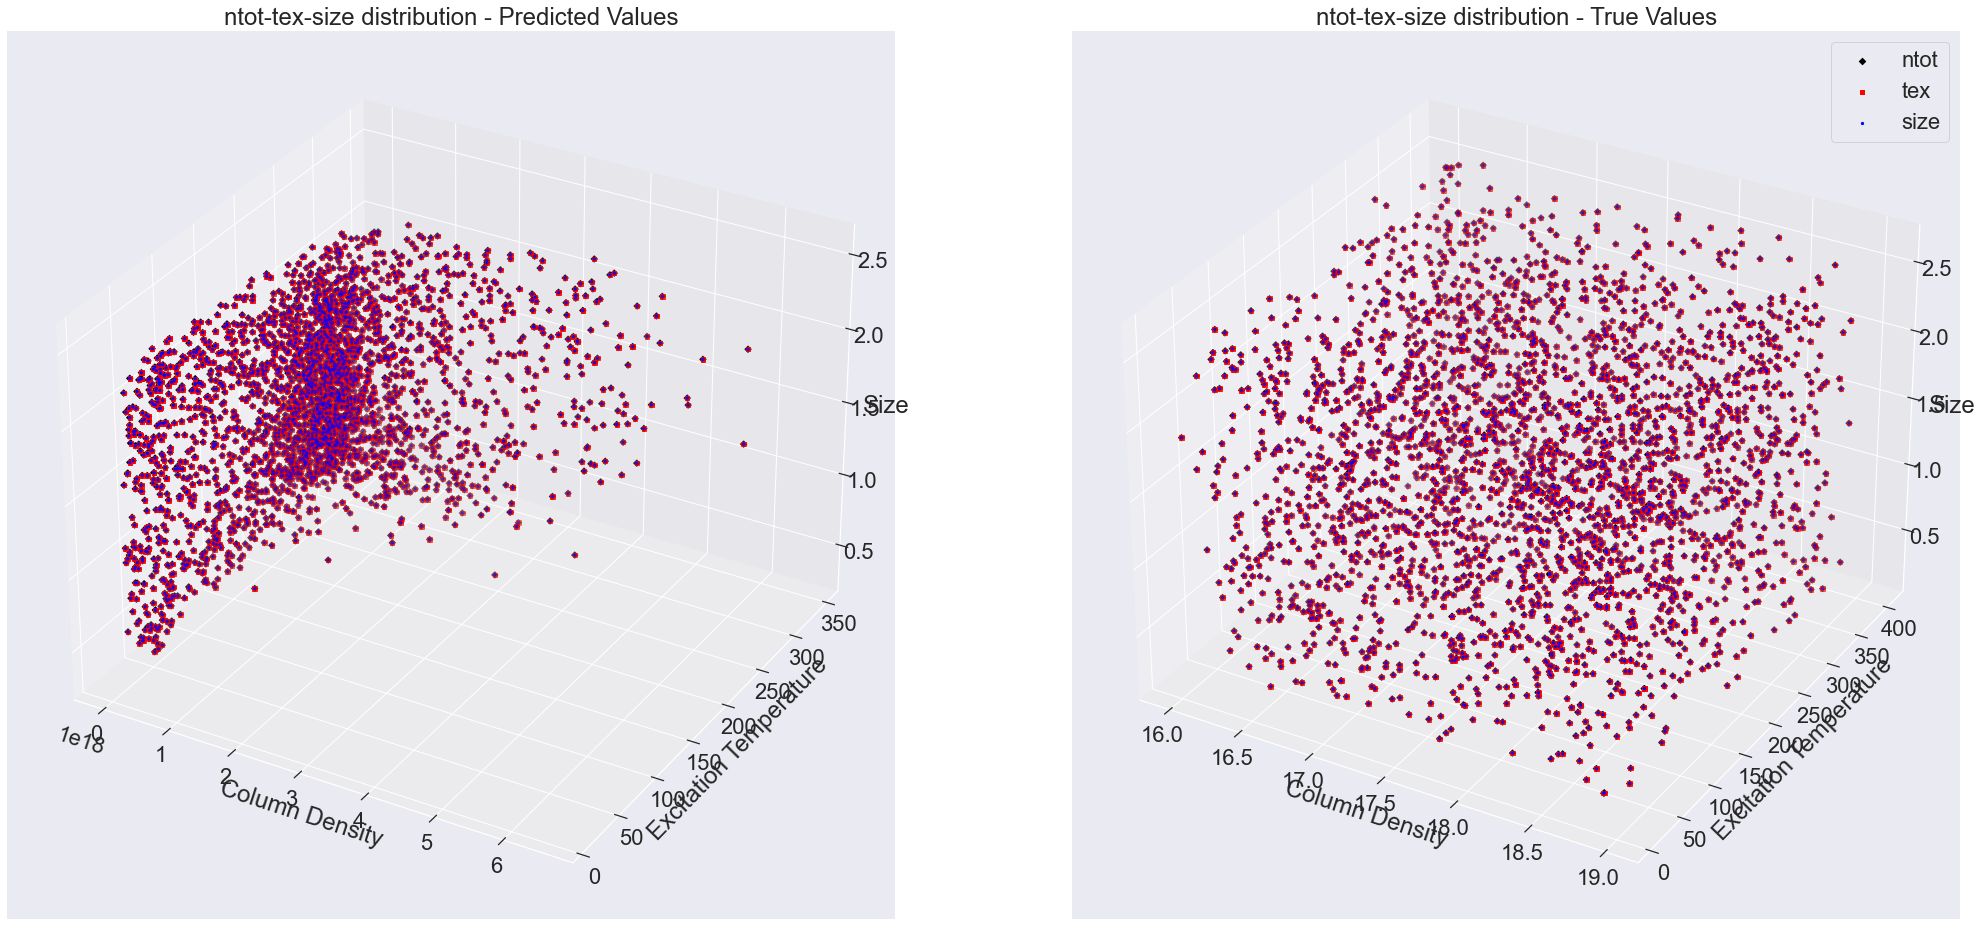

In [56]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    x1 = pred_param_rf['ntot']
    y1 = pred_param_rf['tex']
    z1 = pred_param_rf['size']
    
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density')
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig("data/10K_gen_files/scatter3D_pred_true_10K_RF.png")
plt.show()

All the points are taking up the same position in a 3D space. Not sure if this is how its supposed to be. From my understanding, the Column density is dependent on Temperature, so they take the `x`, and `y` positions while size takes the `z` position.plt

## Hyperparameter Tuning for Random Forest

In [ ]:
# multirf_model = MultiOutputRegressor(
#     RandomForestRegressor(
#         n_estimators=100,
#         max_depth=10,
#         min_samples_split=2,
#         min_samples_leaf=1,
#         min_weight_fraction_leaf=0.0,
#         criterion="squared_error",
#         bootstrap=True,
#         n_jobs=-1,
#         max_samples=None,
# ))

# multrf_hyperparameters = dict(
#     estimator__n_estimators=np.arange(100, 1000, 100),
#     estimator__max_depth=np.arange(10, 150, 10),
#     estimator__min_samples_split=np.arange(2, 10, 2),
#     estimator__min_samples_leaf=np.arange(1, 5, 1),
#     # estimator__min_weight_fraction_leaf=np.arange(0, 0.5, 0.1),
#     # estimator__criterion=["squared_error", "absolute_error"],
#     estimator__max_features=["auto", "sqrt", "log2"],
#     # estimator__max_samples=np.arange(0.5, 1, 0.1),
#     estimator__bootstrap=["True", "False"]
#     )

In [ ]:
# random_search = RandomizedSearchCV(
#     estimator=multirf_model,
#     param_distributions=multrf_hyperparameters,
#     n_iter=100,
#     cv=5,
#     verbose=2,
#     error_score="raise",
#     n_jobs=-1,
#     random_state=42,
#     return_train_score=True
# )

In [ ]:
# # best parameters from tuned model
# regr_tuned_multirf = MultiOutputRegressor(
#     estimator=RandomForestRegressor(
#        n_estimators=800, 
#        min_samples_split=2,
#        min_samples_leaf=1,
#        max_features='auto', 
#        max_depth=130,
#        bootstrap=True,
#        verbose=5
#     )
# )

In [ ]:
# hyper_rf_tuned_model = regr_tuned_multirf.fit(X_train, y_train)

In [ ]:
# y_multirf_tuned_rf = hyper_rf_tuned_model.predict(X_test)

In [ ]:
# # # TODO: interpret the model evaluation metrics
# eval = RegressionMetrics()
# for metric in _metrics:
#     print(metric, ":", eval.get_metric(metric, y_test, y_multirf_tuned_rf))

### True vs Predicted Values - RF Tuned Model

In [ ]:
# fig, axes = plt.subplots(3, 2, figsize=(45,35))
# plt.setp(ax.get_xticklabels(), fontsize=14)
# sns.set_theme(font_scale=2) 
# axes[2,1].set_visible(False)
# axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_tuned_rf[:,0], color='orange', ax=axes[0,0]) # fwhm
# g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_tuned_rf[:,1], color='orange', ax=axes[0,1]) # column density
# g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_tuned_rf[:,2], color='orange', ax=axes[1,0]) # size
# g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_tuned_rf[:,3], color='orange', ax=axes[1,1]) # tex
# g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_tuned_rf[:,4], color='orange', ax=axes[2,0]) # vlsr

# g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
# g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
# g3.set(title='Size', ylabel="predicted values", xlabel="true values")
# g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
# g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

# plt.savefig("data/10K_gen_files/pred_true_10K_tuned_RF.png")
# plt.show()

### Residuals - RF Tuned Model

In [ ]:
# residuals_tuned_rf = (y_test - y_multirf_tuned_rf)
# residuals_tuned_rf

In [ ]:
# fig, axes = plt.subplots(3, 2, figsize=(45,35))
# plt.setp(ax.get_xticklabels(), fontsize=14)
# sns.set_theme(font_scale=2) 
# axes[2,1].set_visible(False)
# axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# # plot the redisual distribution using seaborn
# g1 = sns.residplot(x=y_multirf_tuned_rf[:,0], y=residuals_tuned_rf['fwhm'], lowess=True, ax=axes[0,0], color='orange') # fwhm
# g2 = sns.residplot(x=y_multirf_tuned_rf[:,1], y=residuals_tuned_rf['ntot'], lowess=True, ax=axes[0,1], color='orange') # column density
# g3 = sns.residplot(x=y_multirf_tuned_rf[:,2], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,0], color='orange') # size
# g4 = sns.residplot(x=y_multirf_tuned_rf[:,3], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,1], color='orange') # tex
# g5 = sns.residplot(x=y_multirf_tuned_rf[:,4], y=residuals_tuned_rf['vlsr'], lowess=True, ax=axes[2,0], color='orange') # vlsr
# g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
# g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
# g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
# g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
# g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

# plt.savefig("data/10K_gen_files/residuals_tuned_RF_10K.png")
# plt.show()

## 2. XGBoost Regressor

In [57]:
multixgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        max_leaves=10,
        max_bin=10,
        learning_rate=0.1,
        n_jobs=-1,
        gamma=0,
        min_child_weight=1.0,
        max_delta_step=0,
        importance_type="gain",
        eval_metric=metrics.mean_squared_error
    )
)
multixgb_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            eval_metric=<function mean_squared_error at 0x7f931fd39820>,
                                            gamma=0, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=10,
                                            max_delta_step=0, max_depth=10,
                                            max_leaves=10, min_child_weight=1.0,
                                            missing=nan,
                                            monoton

In [58]:
y_multixgb_pred = multixgb_model.predict(X_test)

In [59]:
for metric in _metrics:
    print(metric, ":", metrics_multirf.get_metric(metric, y_test, y_multixgb_pred))

mae : 7.508944941867919
mse : 480.2598562617991
rmse : 21.91483187847443
mape : fwhm     6.179693
ntot     1.550208
size    23.988930
tex     25.862067
vlsr    11.378303
dtype: float64
r2 : 0.8720782219371612
msle : 21.91483187847443


### save the predicted parameters to a csv file

In [60]:
param_df_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm_pred_xgb', 'ntot_pred_xgb', 'size_pred_xgb', 'tex_pred_xgb', 'vlsr_pred_xgb'])
param_df_xgb['ntot_pred_xgb'] = np.array(10**param_df_xgb['ntot_pred_xgb'])
param_df_xgb.to_csv('data/10K_gen_files/predicted_parameters_xgb.csv')

In [61]:
param_df_xgb.head()

fwhm_pred_xgb  ntot_pred_xgb  size_pred_xgb  tex_pred_xgb  vlsr_pred_xgb
0       4.655095   1.949258e+18       1.249377    226.883408     -18.256773
1       1.496577   2.950531e+17       1.370624    109.868217      20.407202
2       2.864070   4.772346e+16       0.694016    111.874115      -0.211956
3       2.263812   3.458691e+16       0.742605    253.913727      27.868177
4       3.029198   1.759820e+18       1.729101    267.391815      34.710258

### Predicted vs True values - XGB Regressor

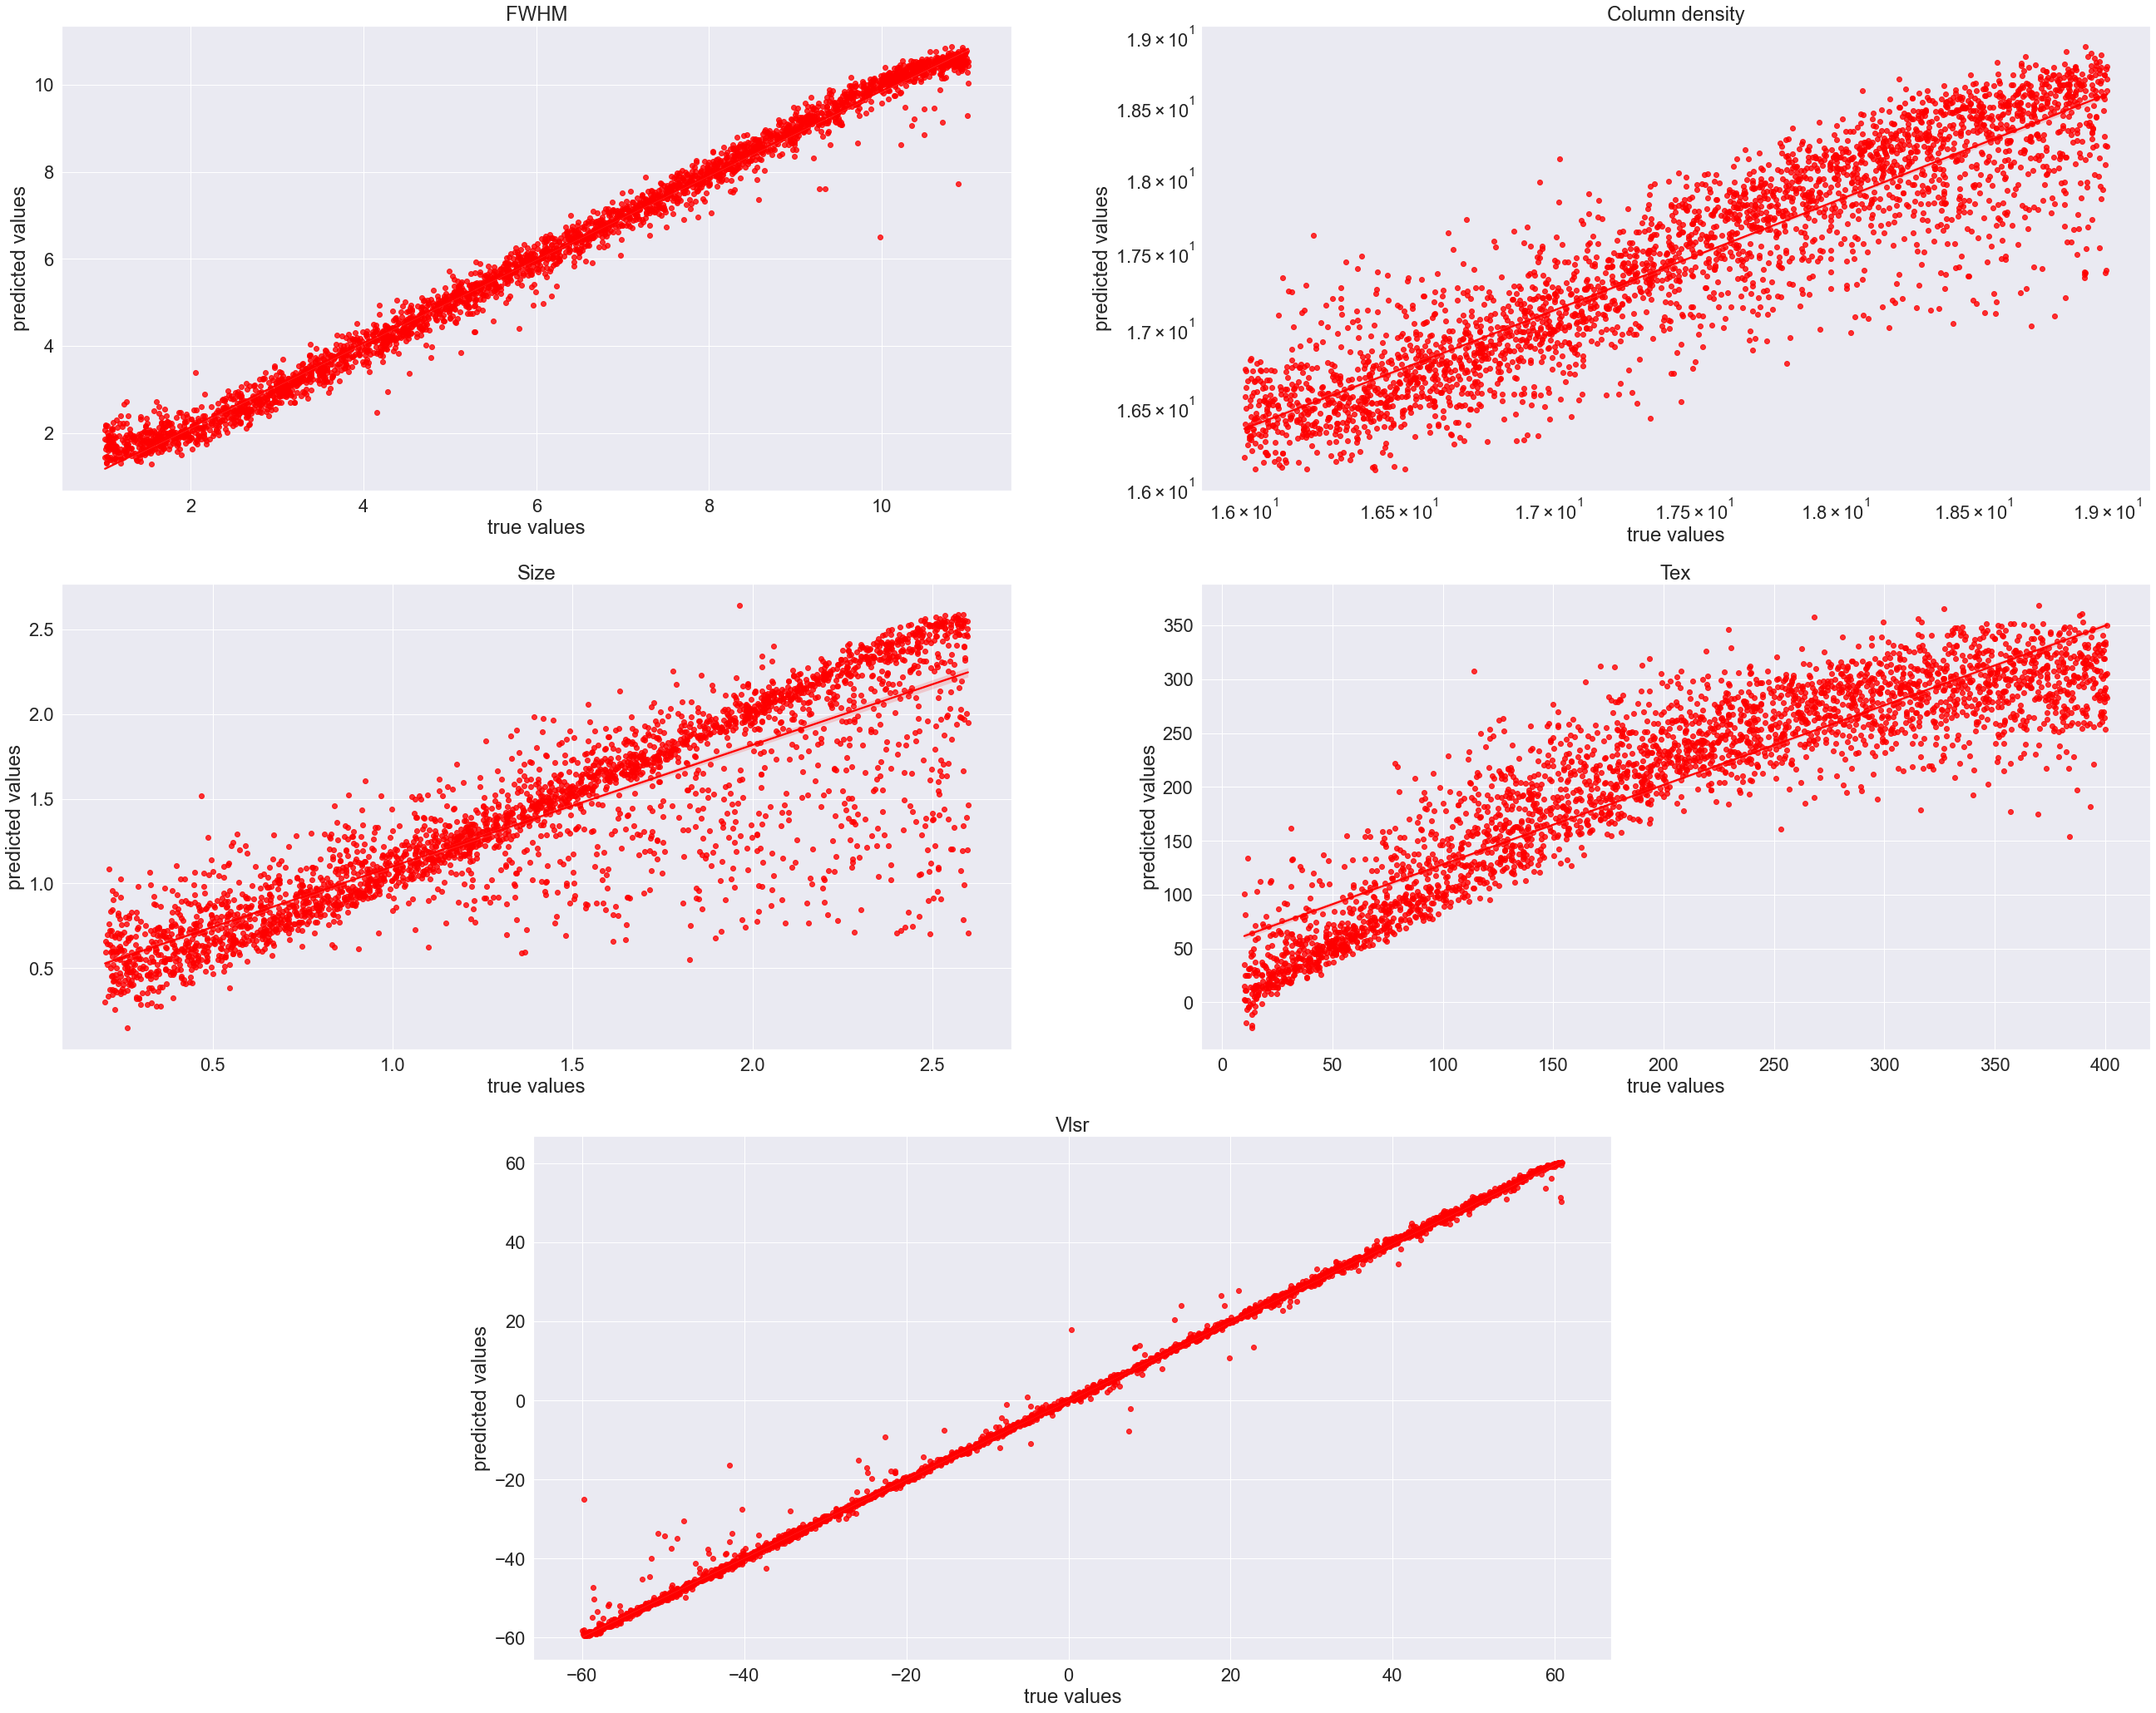

In [62]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:, 0], y=y_multixgb_pred[:,0],color='red', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multixgb_pred[:,1], color='red', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multixgb_pred[:,2], color='red', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multixgb_pred[:,3], color='red', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multixgb_pred[:,4], color='red', ax=axes[2,0]) # vlsr
g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", yscale="log", xscale="log")
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/10K_gen_files/pred_true_10K_XGB.png")
plt.show()

### 3D plots - Columnn density, Excitation temperature and Size - XGB Regressor

In [63]:
pred_param_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_xgb['ntot'] = np.array(10**pred_param_xgb['ntot'])
pred_param_xgb.head()

fwhm          ntot      size         tex       vlsr
0  4.655095  1.949258e+18  1.249377  226.883408 -18.256773
1  1.496577  2.950531e+17  1.370624  109.868217  20.407202
2  2.864070  4.772346e+16  0.694016  111.874115  -0.211956
3  2.263812  3.458691e+16  0.742605  253.913727  27.868177
4  3.029198  1.759820e+18  1.729101  267.391815  34.710258

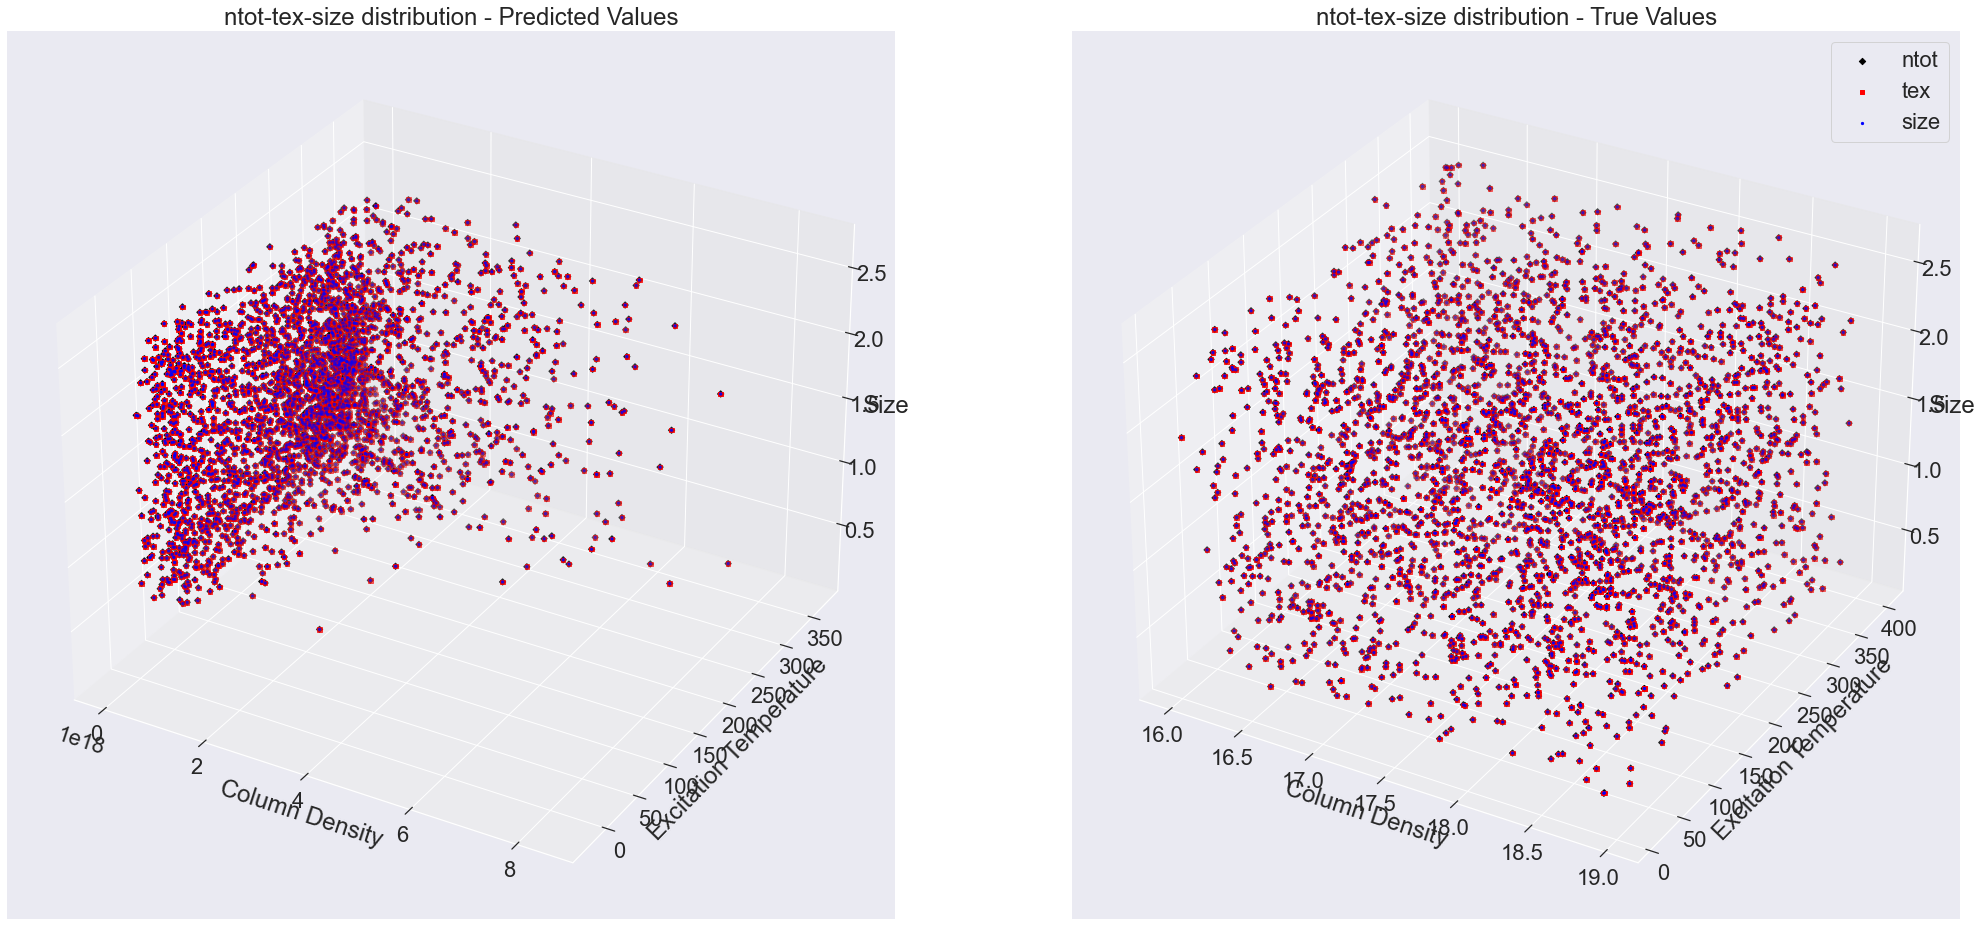

In [64]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')


markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']


x1 = pred_param_xgb['ntot']
y1 = pred_param_xgb['tex']
z1 = pred_param_xgb['size']
    
x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density', )
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig("data/10K_gen_files/scatter3D_pred_true_10K_XGB.png")
plt.show()

### Residuals 3D plot - XGB Regressor

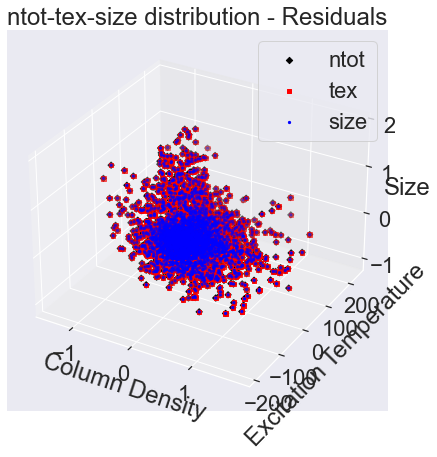

In [65]:
fig = plt.figure(figsize=(15, 7))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_xgb = (y_test - y_multixgb_pred)
# residuals
x1 = residuals_xgb['ntot']
y1 = residuals_xgb['tex']
z1 = residuals_xgb['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

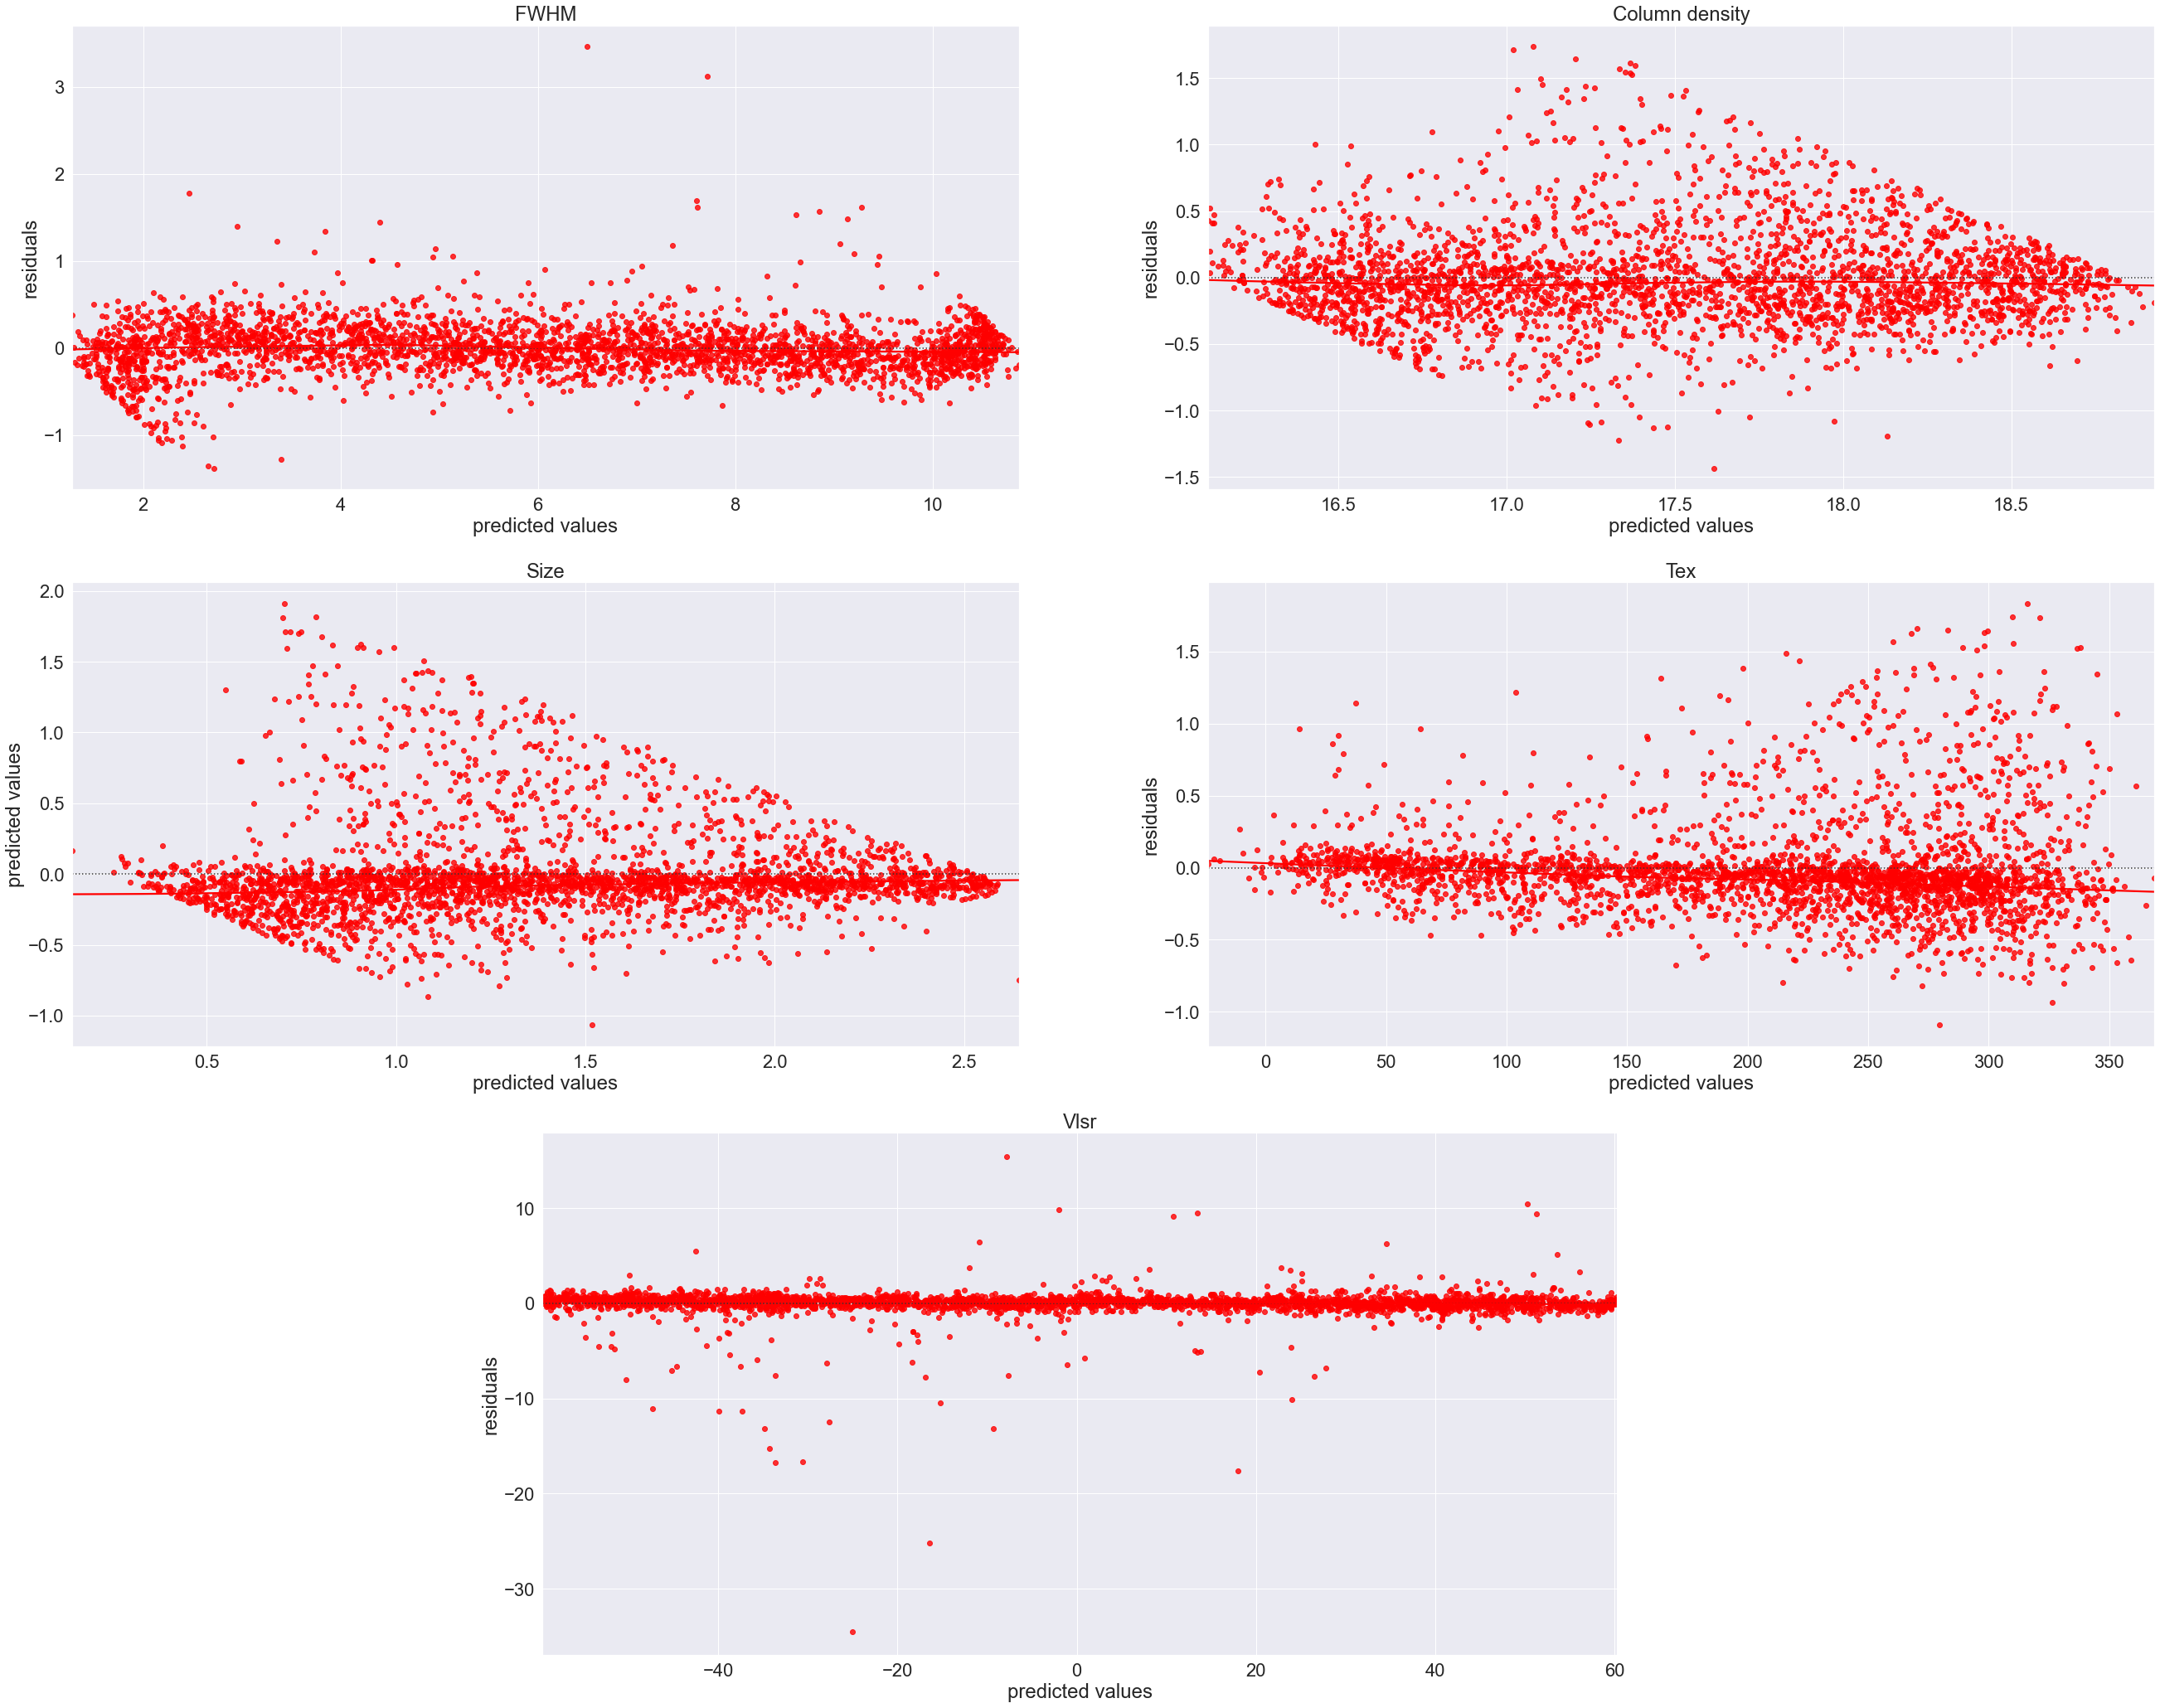

In [66]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multixgb_pred[:,0], y=residuals_xgb['fwhm'], lowess=True, ax=axes[0,0], color='red') # fwhm
g2 = sns.residplot(x=y_multixgb_pred[:,1], y=residuals_xgb['ntot'], lowess=True, ax=axes[0,1], color='red') # column density
g3 = sns.residplot(x=y_multixgb_pred[:,2], y=residuals_xgb['size'], lowess=True, ax=axes[1,0], color='red') # size
g4 = sns.residplot(x=y_multixgb_pred[:,3], y=residuals_xgb['size'], lowess=True, ax=axes[1,1], color='red') # tex
g5 = sns.residplot(x=y_multixgb_pred[:,4], y=residuals_xgb['vlsr'], lowess=True, ax=axes[2,0], color='red') # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/10K_gen_files/residuals_XGB_10K.png")
plt.show()

### XGBoost Hyperparameter Tuning

In [ ]:
# params = dict(
#     estimator__n_estimators = [100, 200, 500],
#     estimator__learning_rate = [0.01, 0.03, 0.1],
#     estimator__max_depth =  [3, 5, 7, 10],
#     estimator__objective = ['reg:squarederror'],
#     estimator__colsample_bytree = [0.5, 0.7]

# )

# xgb_model = MultiOutputRegressor(
#     xgb.XGBRegressor()
# )

# xgb_gridseach = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=params,
#     cv=5,
#     # scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     verbose=1
# )


In [ ]:
# xgb_gridseach.fit(X_train, y_train)

In [ ]:
# xgb_gridseach.best_params_

### Best parameters 

{'estimator__colsample_bytree': 0.5,
 'estimator__learning_rate': 0.03,
 'estimator__max_depth': 10,
 'estimator__n_estimators': 500,
 'estimator__objective': 'reg:squarederror'}

#### Best Fit

In [67]:
#TODO: fill in the best params after tuning
xgb_tuned_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=10,
        colsample_bytree=0.5,
        subsample=0.8,
        min_child_weight=1.0,
        max_delta_step=0,
        importance_type="gain",
        objective='reg:squarederror'
    )
)

In [68]:
xgb_tuned_model.fit(X_train, y_train, verbose=True)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.03,
                                            max_delta_step=0, max_depth=10,
                                            min_child_weight=1.0, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
          

In [69]:
y_multixgb_tuned_pred = xgb_tuned_model.predict(X_test)

### metrics

In [70]:
for metric in _metrics:
    print(metric, ":", metrics_multirf.get_metric(metric, y_test, y_multixgb_tuned_pred))

mae : 7.158324504022827
mse : 434.793068209342
rmse : 20.851692214526427
mape : fwhm     5.254743
ntot     1.449020
size    22.703055
tex     24.237248
vlsr    11.461184
dtype: float64
r2 : 0.8843987131363017
msle : 20.851692214526427


### save the predicted parameters for the tuned model to a csv file

In [71]:
param_df_xgb_tuned = pd.DataFrame(y_multixgb_tuned_pred, columns=['fwhm_pred_xgb', 'ntot_pred_xgb', 'size_pred_xgb', 'tex_pred_xgb', 'vlsr_pred_xgb'], index=X_test.index)
param_df_xgb_tuned['ntot_pred_xgb'] = np.array(10**param_df_xgb_tuned['ntot_pred_xgb'])
param_df_xgb_tuned.to_csv('data/10K_gen_files/predicted_parameters_xgb_tuned.csv')

In [72]:
param_df_xgb_tuned.head()

fwhm_pred_xgb  ntot_pred_xgb  size_pred_xgb  tex_pred_xgb  vlsr_pred_xgb
6252       4.404874   1.268483e+18       1.299070    236.366272     -18.443958
4684       1.769515   2.106496e+17       1.492437    102.482979      15.756020
1731       2.990187   5.627094e+16       0.703356    101.450523       0.324226
4742       2.138654   3.704450e+16       0.846053    260.372284      27.496729
4521       3.542979   1.599166e+18       1.848067    260.738434      34.973225